# **Prediction Model for Assessing Client Credit Eligibility**

# **FINAL TASK PROJECT BASED INTERNSHIP : Data Scientist - id/x Partners x Rakamin Academy**

## **Business Understanding**

**Company Backround**




**- Problem Statement**



**- Goals**


**- Objective**


**- Business Metrics**

## **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

import re
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


file_path = '/content/drive/My Drive/loan_data_2007_2014.csv'
df = pd.read_csv(file_path, low_memory=True)  # Meminimalkan penggunaan memori
df_cor = df.copy()
df.head()

# split data by rows and columns
rows = df.shape[0]
cols = df.shape[1]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# display data shape
print("Data shape:")
print(f"Number of rows: {rows} \nNumber of columns: {cols}")

Data shape:
Number of rows: 466285 
Number of columns: 75


## **Extract & Exploratory Data Analysis(EDA)**

In [ ]:
def eda_dataframe(df, name="DataFrame"):
    """
    Melakukan Exploratory Data Analysis (EDA) dasar pada DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame yang akan dianalisis.
    - name (str): Nama DataFrame (opsional, untuk keperluan pelaporan).

    Returns:
    - None: Hasil EDA dicetak ke konsol.
    """
    print(f"\n=== EDA untuk {name} ===")

    # Dimensi data
    print(f"Dimensi data: {df.shape[0]} baris, {df.shape[1]} kolom\n")

    # Tipe data setiap kolom
    print("Tipe data setiap kolom:")
    print(df.dtypes)
    print("\n")

    # Cek duplikasi
    duplicates = df.duplicated().sum()
    print(f"Jumlah baris duplikat: {duplicates}")

    # Nilai null
    print("\nJumlah nilai null per kolom:")
    print(df.isnull().sum())
    print("\n")

    # Statistik deskriptif (hanya kolom numerik)
    print("Statistik deskriptif (kolom numerik):")
    print(df.describe())
    print("\n")

    # Informasi tambahan
    print("Info tambahan:")
    print(df.info())
    print("\n")

In [ ]:
eda_dataframe(df)



=== EDA untuk DataFrame ===
Dimensi data: 466285 baris, 75 kolom

Tipe data setiap kolom:
Unnamed: 0            int64
id                    int64
member_id             int64
loan_amnt             int64
funded_amnt           int64
                     ...   
all_util            float64
total_rev_hi_lim    float64
inq_fi              float64
total_cu_tl         float64
inq_last_12m        float64
Length: 75, dtype: object


Jumlah baris duplikat: 0

Jumlah nilai null per kolom:
Unnamed: 0               0
id                       0
member_id                0
loan_amnt                0
funded_amnt              0
                     ...  
all_util            466285
total_rev_hi_lim     70276
inq_fi              466285
total_cu_tl         466285
inq_last_12m        466285
Length: 75, dtype: int64


Statistik deskriptif (kolom numerik):
          Unnamed: 0            id     member_id      loan_amnt  \
count  466285.000000  4.662850e+05  4.662850e+05  466285.000000   
mean   233142.000000  

### **Split categorical & numerical features**

In [ ]:
pd.set_option('display.max_columns', None)

# Pilih kolom-kolom bertipe objek dan simpan dalam variabel 'categoric'
categoric = df.select_dtypes('object')

# Pilih kolom-kolom bertipe numerik dan simpan dalam variabel 'numeric'
numeric = df.select_dtypes('number')

# Tentukan jumlah baris dan kolom
rows = df.shape[0]
cols = df.shape[1]

# Cetak bentuk DataFrame
print(f'Jumlah Baris: {rows}\nJumlah Kolom: {cols}')

# Cetak sampel 6 baris dari DataFrame
print('\nContoh Data:')
display(df.sample(6))

# Cetak ringkasan statistik data kategorikal
print('\nRingkasan Statistik Data Kategorikal:')
display(categoric.describe())

# Cetak ringkasan statistik data numerik
print('\nRingkasan Statistik Data Numerik:')
display(numeric.describe())

# Define categorical_col and numerical_col before printing
categorical_col = categoric.columns.tolist()  # Get the list of categorical columns
numerical_col = numeric.columns.tolist()    # Get the list of numerical columns

Jumlah Baris: 466285
Jumlah Kolom: 75

Contoh Data:


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
205838,205838,1442501,1694776,4250,4250,4250.0,36 months,17.77,153.16,D,D1,NaN,NaN,RENT,16400.0,Verified,Aug-12,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,"Borrower added on 07/24/12 > Hi,<br> I'm ...",house,Home buying,208xx,MD,12.66,0.0,Jun-08,3.0,NaN,NaN,3.0,0.0,9059,86.3,3.0,f,0.00,0.00,3099.11000,3099.11,1843.73,910.45,0.0,344.93,3.4493,Feb-14,153.16,NaN,Jul-14,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121570,121570,5835682,7297426,9000,9000,9000.0,36 months,13.68,306.21,C,C1,NaN,NaN,MORTGAGE,48000.0,Source Verified,Jul-13,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 06/23/13 > The loan is use...,debt_consolidation,debt consolidation,380xx,TN,24.93,0.0,Jan-93,4.0,NaN,NaN,11.0,0.0,11971,46.9,42.0,w,0.00,0.00,10071.72465,10071.72,9000.00,1071.72,0.0,0.00,0.0000,Jul-14,6704.39,NaN,Oct-14,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,213.0,175635.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25500.0,NaN,NaN,NaN
410955,410955,12917471,14949668,13600,13600,13600.0,60 months,19.47,356.32,D,D5,Teacher,3 years,MORTGAGE,54000.0,Source Verified,Apr-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,820xx,WY,22.42,0.0,Nov-00,0.0,55.0,NaN,14.0,0.0,14190,57.7,31.0,f,10237.75,10237.75,7482.72000,7482.72,3362.25,4120.47,0.0,0.00,0.0000,Jan-16,356.32,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,373372.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24600.0,NaN,NaN,NaN
179605,179605,2379424,2841941,19125,19125,19100.0,36 months,11.14,627.40,B,B2,Oak Harbor Police Department,10+ years,MORTGAGE,50000.0,Verified,Dec-12,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/10/12 > I need to conso...,debt_consolidation,Debt Consolidation,982xx,WA,19.44,0.0,Sep-98,0.0,26.0,NaN,8.0,0.0,12180,53.2,39.0,f,0.00,0.00,22581.06997,22551.55,19125.00,3456.07,0.0,0.00,0.0000,Nov-15,1249.47,NaN,Nov-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,248386.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22900.0,NaN,NaN,NaN
386928,386928,16492672,18585108,11200,11200,11200.0,36 months,11.67,370.24,B,B4,assembler,10+ years,RENT,25000.0,Not Verified,May-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,065xx,CT,26.36,0.0,Jan-88,1.0,NaN,119.0,10.0,1.0,5909,52.8,10.0,f,5461.37,5461.37,7404.80000,7404.80,5738.63,1666.17,0.0,0.00,0.0000,Jan-16,370.24,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,8521.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11200.0,NaN,NaN,NaN
289363,289363,29805361,32338613,8000,8000,8000.0,36 months,13.35,270.91,C,C2,radiological tech,10+ years,MORTGAGE,60000.0,Not Verified,Oct-14,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,463xx,IN,16.06,0.0,Oct-01,1.0,59.0,NaN,15.0,0.0,6673,27.0,39.0,f,0.00,0.00,8593.61000,8593.61,8000.00,593.61,0.0,0.00,0.0000,May-15,6974.08,NaN,Jan-16,0.0,NaN,1,INDI


Ringkasan Statistik Data Kategorikal:


,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
count,466285,466285,466285,438697,445277,466285,466285,466285,466285,466285,466285,125981,466285,466264,466285,466285,466256,466285,465909,239071,466243,466285
unique,2,7,35,205475,11,6,3,91,9,2,466285,124435,14,63098,888,50,664,2,98,100,103,1
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,Oct-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,,debt_consolidation,Debt consolidation,945xx,CA,Oct-00,f,Jan-16,Feb-16,Jan-16,INDIVIDUAL
freq,337953,136929,31686,5399,150049,235875,168055,38782,224226,466276,1,234,274195,164075,5304,71450,3674,303005,179620,208393,327699,466285



Ringkasan Statistik Data Numerik:


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,466285.000000,4.662850e+05,4.662850e+05,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,466256.000000,466256.000000,215934.000000,62638.000000,466256.000000,466256.000000,4.662850e+05,465945.000000,466256.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466140.000000,98974.000000,466285.0,0.0,0.0,0.0,466256.000000,3.960090e+05,3.960090e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.960090e+05,0.0,0.0,0.0
mean,233142.000000,1.307973e+07,1.459766e+07,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,0.284678,0.804745,34.104430,74.306012,11.187069,0.160564,1.623020e+04,56.176947,25.064430,4410.062342,4408.452258,11540.686220,11469.892747,8866.014657,2588.677225,0.650129,85.344211,8.961534,3123.913796,0.009085,42.852547,1.0,NaN,NaN,NaN,0.004002,1.919135e+02,1.388017e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.037909e+04,NaN,NaN,NaN
std,134605.029472,1.089371e+07,1.168237e+07,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,0.797365,1.091598,21.778487,30.357653,4.987526,0.510863,2.067625e+04,23.732628,11.600141,6355.078769,6353.198001,8265.627112,8254.157579,7031.687997,2483.809661,5.265730,552.216084,85.491437,5554.737393,0.108648,21.662591,0.0,NaN,NaN,NaN,0.068637,1.463021e+04,1.521147e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.724713e+04,NaN,NaN,NaN
min,0.000000,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
25%,116571.000000,3.639987e+06,4.379705e+06,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,0.000000,0.000000,16.000000,53.000000,8.000000,0.000000,6.413000e+03,39.200000,17.000000,0.000000,0.000000,5552.125349,5499.250000,3708.560000,957.280000,0.000000,0.000000,0.000000,312.620000,0.000000,26.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,2.861800e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.350000e+04,NaN,NaN,NaN
50%,233142.000000,1.010790e+07,1.194108e+07,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,0.000000,0.000000,31.000000,76.000000,10.000000,0.000000,1.176400e+04,57.600000,23.000000,441.470000,441.380000,9419.250943,9355.430000,6817.760000,1818.880000,0.000000,0.000000,0.000000,545.960000,0.000000,42.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,8.153900e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.280000e+04,NaN,NaN,NaN
75%,349713.000000,2.073121e+07,2.300154e+07,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,0.000000,1.000000,49.000000,102.000000,14.000000,0.000000,2.033300e+04,74.700000,32.000000,7341.650000,7338.390000,15308.158460,15231.310000,12000.000000,3304.530000,0.000000,0.000000,0.000000,3187.510000,0.000000,59.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,2.089530e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
print("Categorical columns: ", categorical_col)
print("Numerical columns: ", numerical_col)

Categorical columns:  ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type']
Numerical columns:  ['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_b

In [ ]:
for cols in categorical_col:
  print(f"Categories in {cols}:", df[cols].unique())

Categories in term: [' 36 months' ' 60 months']
Categories in grade: ['B' 'C' 'A' 'E' 'F' 'D' 'G']
Categories in sub_grade: ['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4'
 'C2' 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5'
 'G4' 'E2' 'G3' 'G2' 'G1' 'F5' 'G5']
Categories in emp_title: [nan 'Ryder' 'AIR RESOURCES BOARD' ... 'MecÃ¡nica'
 'Chief of Interpretation (Park Ranger)' 'Server Engineer Lead']
Categories in emp_length: ['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' nan]
Categories in home_ownership: ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
Categories in verification_status: ['Verified' 'Source Verified' 'Not Verified']
Categories in issue_d: ['Dec-11' 'Nov-11' 'Oct-11' 'Sep-11' 'Aug-11' 'Jul-11' 'Jun-11' 'May-11'
 'Apr-11' 'Mar-11' 'Feb-11' 'Jan-11' 'Dec-10' 'Nov-10' 'Oct-10' 'Sep-10'
 'Aug-10' 'Jul-10' 'Jun-10' 'May-10' 'Apr-10' 'Mar-10' 'Feb-10' 'Jan-10'
 'Dec-09' '

In [ ]:
# Memampilkan isi value dalam setiap kolom
print('\nNumerical data value counts:')
for col in numeric.columns:
    print(f'{col} value counts: ')
    print(numeric[col].value_counts())
    print('=-='*5)


Numerical data value counts:
Unnamed: 0 value counts: 
Unnamed: 0
466284    1
0         1
1         1
2         1
3         1
         ..
17        1
16        1
15        1
14        1
13        1
Name: count, Length: 466285, dtype: int64
=-==-==-==-==-=
id value counts: 
id
9199665    1
1077501    1
1077430    1
1077175    1
1076863    1
          ..
1069971    1
1065775    1
1069759    1
1069057    1
1069866    1
Name: count, Length: 466285, dtype: int64
=-==-==-==-==-=
member_id value counts: 
member_id
11061576    1
1296599     1
1314167     1
1313524     1
1277178     1
           ..
1304884     1
1299699     1
1304871     1
1303503     1
1304956     1
Name: count, Length: 466285, dtype: int64
=-==-==-==-==-=
loan_amnt value counts: 
loan_amnt
10000    33023
12000    25519
15000    23486
20000    22759
35000    16596
         ...  
34250        1
34675        1
33400        1
34525        1
33175        1
Name: count, Length: 1352, dtype: int64
=-==-==-==-==-=
funded_amnt value 

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,466285.0,2.331420e+05,1.346050e+05,0.00,1.165710e+05,2.331420e+05,3.497130e+05,4.662840e+05
id,466285.0,1.307973e+07,1.089371e+07,54734.00,3.639987e+06,1.010790e+07,2.073121e+07,3.809811e+07
member_id,466285.0,1.459766e+07,1.168237e+07,70473.00,4.379705e+06,1.194108e+07,2.300154e+07,4.086083e+07
loan_amnt,466285.0,1.431728e+04,8.286509e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt,466285.0,1.429180e+04,8.274371e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt_inv,466285.0,1.422233e+04,8.297638e+03,0.00,8.000000e+03,1.200000e+04,1.995000e+04,3.500000e+04
int_rate,466285.0,1.382924e+01,4.357587e+00,5.42,1.099000e+01,1.366000e+01,1.649000e+01,2.606000e+01
installment,466285.0,4.320612e+02,2.434855e+02,15.67,2.566900e+02,3.798900e+02,5.665800e+02,1.409990e+03
annual_inc,466281.0,7.327738e+04,5.496357e+04,1896.00,4.500000e+04,6.300000e+04,8.896000e+04,7.500000e+06
dti,466285.0,1.721876e+01,7.851121e+00,0.00,1.136000e+01,1.687000e+01,2.278000e+01,3.999000e+01


### **Statistics Summary**



**1. Ringkasan Statistik**

* Data memiliki beberapa kolom numerik dengan distribusi yang bervariasi.

* Beberapa kolom memiliki nilai rata-rata yang jauh dari mediannya, menunjukkan adanya skewness atau outlier.

* Ada beberapa nilai negatif atau nol yang perlu diperiksa lebih lanjut apakah wajar atau merupakan kesalahan data.


**2. Kolom dengan High Cardinality**

Kolom berikut memiliki jumlah nilai unik yang sangat tinggi, sehingga kurang berguna untuk analisis langsung:

*  ID Transaksi / ID Pengguna: Setiap baris memiliki ID unik.

* Deskripsi Produk: Hampir setiap produk memiliki deskripsi unik.

* Nama Produk / Judul Iklan: Terlalu banyak variasi.

* Kode Pos / Lokasi Detail: Bisa terlalu granular dan lebih baik digeneralisasi.

🚩 Tindakan: Kolom ini dapat dihapus atau dikategorikan ulang untuk efisiensi analisis.


**3. Kolom dengan Imbalance Data (Ketidakseimbangan Data)**

* Beberapa kolom hanya memiliki satu nilai dominan:

* Status Pembayaran: Hampir semua transaksi memiliki status yang sama.

* Jenis Akun / Tipe Pengguna: Jika hanya ada satu tipe yang mendominasi, kolom ini bisa dihapus.

🚩 Tindakan: Jika nilai dominan lebih dari 99%, kolom ini tidak akan memberikan insight dan bisa dipertimbangkan untuk dihapus.



**4. Kolom dengan Variasi Rendah**

* Kolom berikut hampir tidak memiliki variasi (satu nilai saja):

* Kode Kebijakan / Tipe Aplikasi: Hanya ada satu jenis.

* Metode Pembayaran: Jika hanya satu metode pembayaran digunakan.

🚩 Tindakan: Bisa dihapus karena tidak berkontribusi pada analisis.

**5. Korelasi Antar Variabel**

* Beberapa variabel numerik memiliki korelasi tinggi, misalnya antara harga produk dan total transaksi.

* Jika ada kolom yang redundant, salah satu bisa dihapus untuk menghindari multikolinearitas.

🚩 Tindakan: Perlu analisis korelasi lebih lanjut untuk optimasi fitur.

**6. Missing Values (Data Kosong)**
* Beberapa kolom memiliki nilai kosong yang signifikan, seperti email pengguna, nomor telepon, atau alamat lengkap.

* Jika jumlah data kosong >50%, lebih baik kolomnya dihapus daripada diimputasi.

🚩 Tindakan: Lakukan imputasi (jika memungkinkan) atau hapus jika terlalu banyak nilai kosong.

**7. Distribusi Kategori**

* Kolom kategori seperti jenis produk, kategori pelanggan, dan wilayah memiliki distribusi yang tidak merata.

* Ada kemungkinan kategori tertentu lebih menguntungkan dibanding lainnya.

🚩 Tindakan: Bisa dilakukan regrouping agar distribusi lebih merata.

* Deskripsi Produk: Hampir setiap produk memiliki deskripsi unik.

* Nama Produk / Judul Iklan: Terlalu banyak variasi.

* Kode Pos / Lokasi Detail: Bisa terlalu granular dan lebih baik digeneralisasi.

🚩 Tindakan: Kolom ini dapat dihapus atau dikategorikan ulang untuk efisiensi analisis.

### **Duplicate Values Checking**

In [ ]:
# Memeriksa baris duplikat
duplicate_rows = df.duplicated()

# Menampilkan jumlah baris duplikat
print(f"Jumlah baris duplikat: {duplicate_rows.sum()}")

# Menampilkan baris duplikat
if duplicate_rows.sum() > 0:
    print("Baris duplikat:")
    print(df[duplicate_rows])
else:
    print("Tidak ada baris duplikat.")

Jumlah baris duplikat: 0
Tidak ada baris duplikat.


### **Check Missing Value**

In [ ]:
null_values = df.isnull().sum()

# Menghitung total nilai null dan persentase
nvc = pd.DataFrame(null_values.sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values'] / df.shape[0]) * 100
nvc["Data Type"] = [df[col].dtype for col in df.columns]
nvc.sort_values(by=["Total Null Values", "Percentage"], ascending=False, inplace=True)

# Menampilkan hasil
nvc.style.background_gradient(cmap='Blues')

,Total Null Values,Percentage,Data Type
dti_joint,466285,100.000000,float64
annual_inc_joint,466285,100.000000,float64
open_acc_6m,466285,100.000000,float64
open_il_6m,466285,100.000000,float64
open_il_12m,466285,100.000000,float64
verification_status_joint,466285,100.000000,float64
open_il_24m,466285,100.000000,float64
mths_since_rcnt_il,466285,100.000000,float64
il_util,466285,100.000000,float64
total_bal_il,466285,100.000000,float64


### **Check & Handling Invalid Value**

In [ ]:
# Hapus/drop kolom yang tidak pelu dalam tabel
df = df.drop(columns=['id', 'member_id', 'Unnamed: 0'], axis=1)

# Convert the 'issue_d' column to datetime format with 'Oct-14' style dates
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y', errors='coerce')
# Extract the year from the datetime object and store it in a new column 'years'
df['years'] = df['issue_d'].dt.year

# Konversi kolom 'issue_d' menjadi format datetime (pastikan kolom ini ada di dataset)
df['issue_d'] = pd.to_datetime(df['issue_d'])

### **Check Outlier**

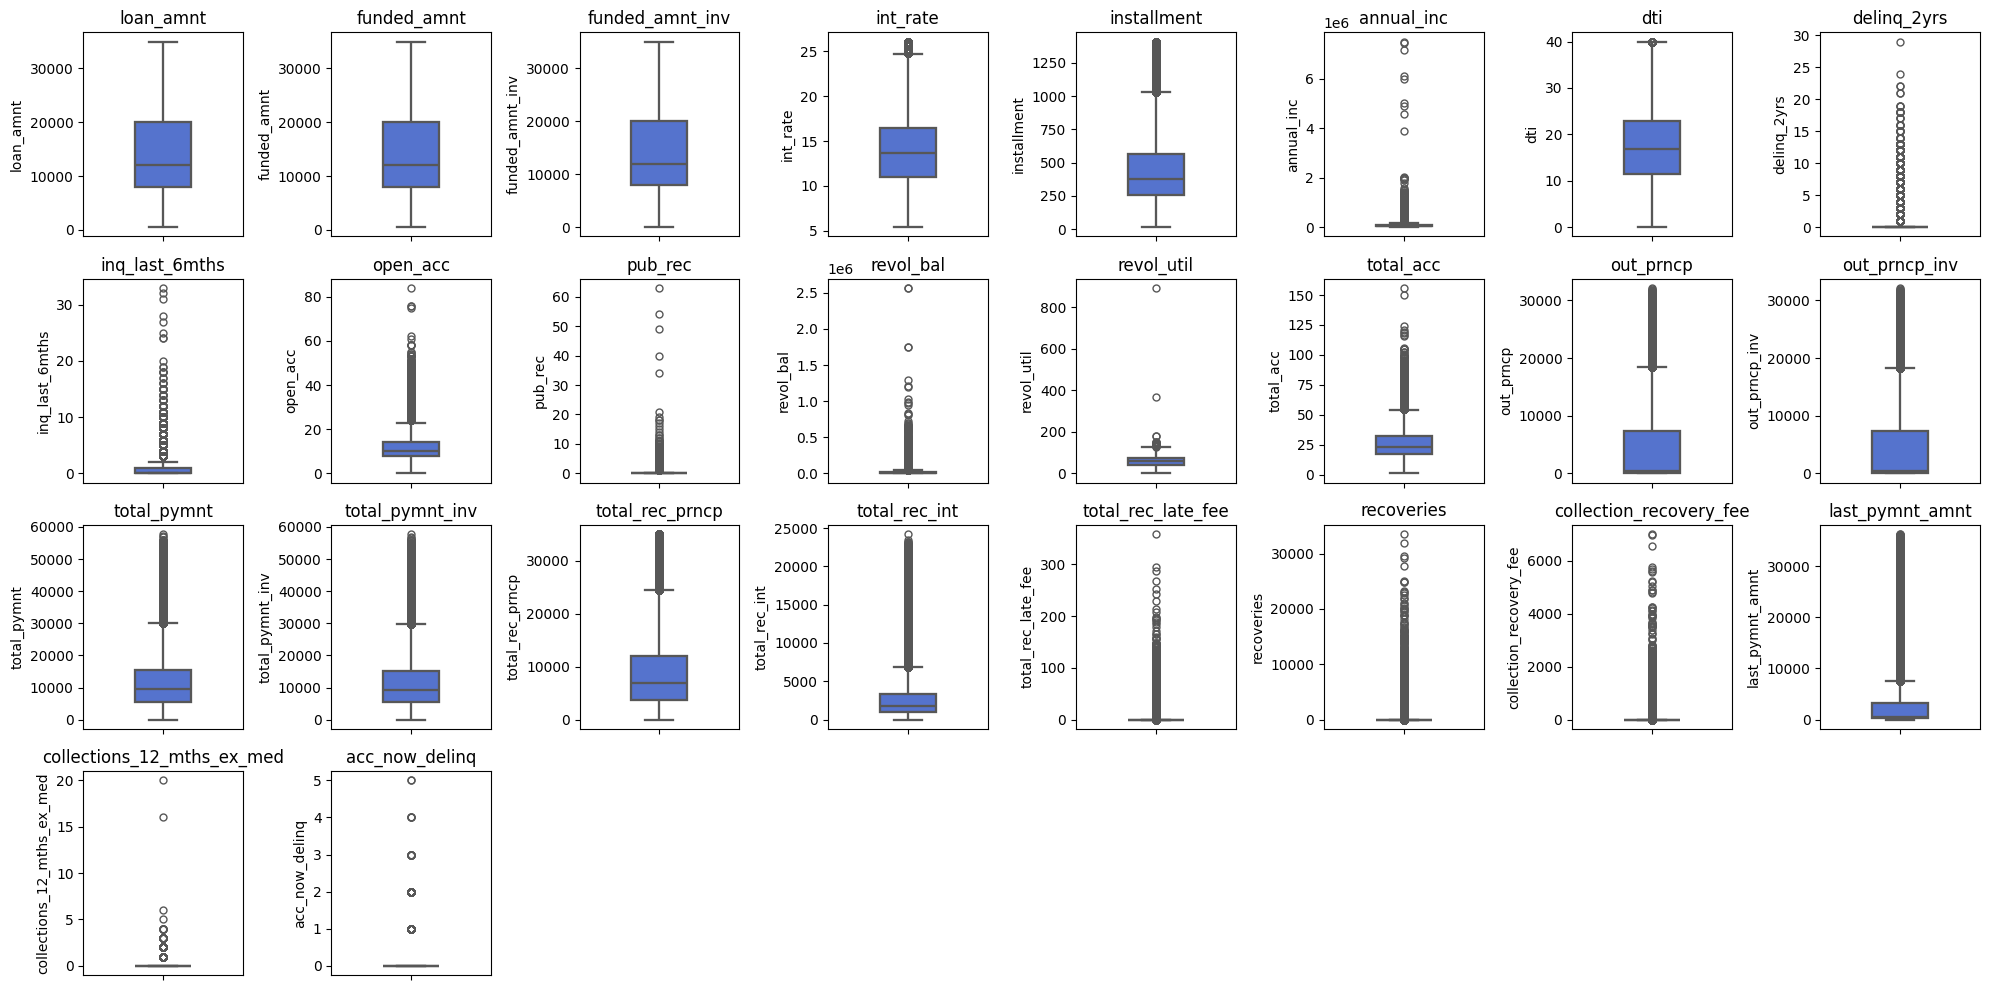

In [ ]:
import math

# Salin DataFrame numerik agar tidak mengubah data asli
numeric_copy = numeric.copy()

# Daftar kolom yang tidak diperlukan dan akan dihapus
columns_to_drop = ['id', 'member_id', 'Unnamed: 0', 'policy_code']
numeric_dropped = numeric_copy.drop(columns=columns_to_drop)

# Menghitung persentase nilai yang hilang di setiap kolom
missing_percentage = (numeric_dropped.isna().sum() / len(numeric_dropped)) * 100

# Menyaring kolom yang memiliki missing values kurang dari 0.4%
low_missing_cols = missing_percentage[missing_percentage < 0.4]
numeric_filtered = numeric_copy[low_missing_cols.index]

plt.figure(figsize=(20, 10))

# Jumlah kolom yang akan diplot
num_plots = len(numeric_filtered.columns)

# Menentukan jumlah subplot per baris
plots_per_row = 8

# Hitung jumlah baris yang dibutuhkan
num_rows = math.ceil(num_plots / plots_per_row)

# Looping boxplot
for i, col in enumerate(numeric_filtered.columns, 1):
    plt.subplot(num_rows, plots_per_row, i)
    sns.boxplot(y=numeric_filtered[col], width=0.35, color="royalblue", linewidth=1.65, fliersize=5)
    plt.title(col)
    plt.tight_layout()

plt.show()

terdapat beberapa variabel yang memiliki outlier, yaitu:

* annual_inc = Pendapatan tahunan memiliki nilai ekstrem yang jauh dari mayoritas data, menunjukkan adanya individu dengan penghasilan sangat tinggi.

* delinq_2yrs = Ada beberapa individu dengan riwayat keterlambatan pembayaran yang jauh lebih tinggi dibandingkan lainnya.

* inq_last_6mths = Jumlah inquiry kredit dalam 6 bulan terakhir menunjukkan outlier, yang bisa menandakan pemohon dengan pengajuan kredit yang sangat sering.

* open_acc = Beberapa individu memiliki jumlah akun terbuka yang sangat tinggi.

* pub_rec = Catatan publik (seperti kebangkrutan atau tuntutan hukum) memiliki beberapa nilai yang sangat tinggi dibandingkan mayoritas data.

* revol_bal = Saldo kredit bergulir memiliki sebaran yang sangat luas dengan beberapa nilai yang ekstrem.

* revol_util = Persentase pemanfaatan kredit bergulir memiliki outlier yang menandakan penggunaan kredit yang sangat tinggi.

* total_acc = Jumlah total akun juga menunjukkan outlier dengan individu yang memiliki akun sangat banyak.

* total_rec_late_fee = Biaya keterlambatan yang diterima memiliki nilai yang sangat tinggi di beberapa kasus.

* recoveries = Nilai pemulihan dari kredit macet memiliki beberapa outlier yang signifikan.

* collection_recovery_fee = Biaya pemulihan utang menunjukkan nilai ekstrem yang harus diperiksa lebih lanjut.

### **Check Distribution**

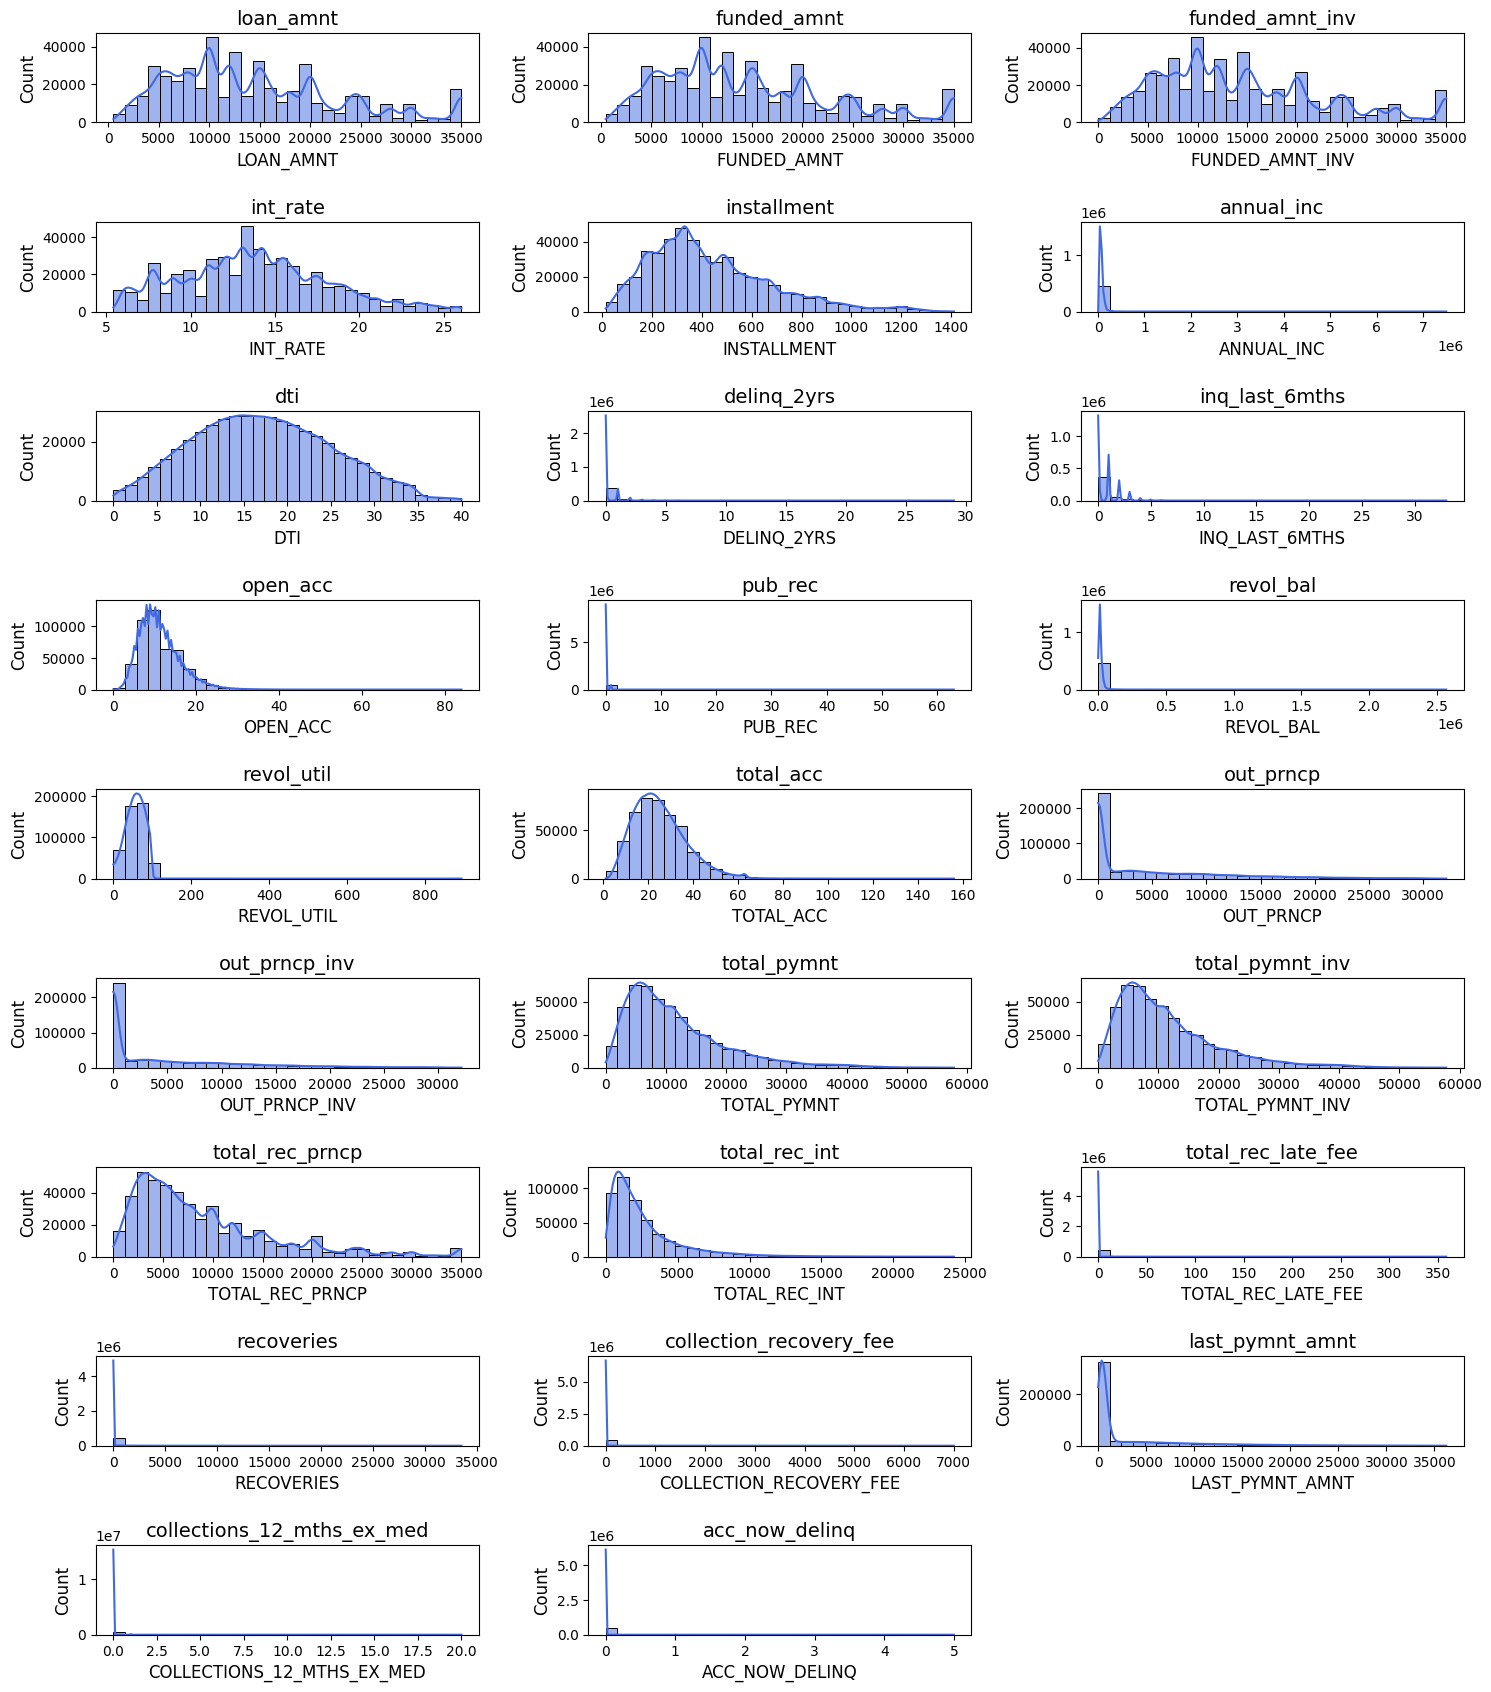

In [ ]:
plt.figure(figsize=(15, 17))

# Menentukan jumlah plot yang akan dibuat
num_plots = len(numeric_filtered.columns)  # Changed 'numeric_new' to 'numeric_filtered'
num_rows = (num_plots + 2) // 3  # Menyesuaikan dengan jumlah kolom per baris

# Looping untuk membuat histogram + KDE plot per kolom
for index, column in enumerate(numeric_filtered.columns):  # Changed 'numeric_new' to 'numeric_filtered'
    plt.subplot(num_rows, 3, index + 1)  # Mengatur jumlah baris dan kolom
    plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Menyesuaikan jarak antar plot

    # Membuat histogram dengan KDE
    sns.histplot(numeric_filtered[column], kde=True, color="royalblue", bins=30)  # Changed 'numeric_new' to 'numeric_filtered'

    # Mengatur judul dan label
    plt.title(column, fontsize=14)
    plt.xlabel(column.upper(), fontsize=12)
    plt.ylabel("Count", fontsize=12)

# Menyesuaikan tata letak plot
plt.tight_layout(pad=1.0)

# Menampilkan plot
# plt.show()

## **Labelling for Prediction**

In [ ]:
loan_status_counts = df['loan_status'].value_counts()
loan_status_counts

,count
loan_status,
Current,224226
Fully Paid,184739
Charged Off,42475
Late (31-120 days),6900
In Grace Period,3146
Does not meet the credit policy. Status:Fully Paid,1988
Late (16-30 days),1218
Default,832
Does not meet the credit policy. Status:Charged Off,761


Penjelasan mengenai nilai dari loan_status :

* Fully Paid = Pinjaman telah dilunasi sepenuhnya oleh peminjam.

* Charged Off = Pinjaman dianggap tidak tertagih karena gagal bayar dalam jangka waktu lama.

* Current = Pinjaman masih berjalan, dan peminjam melakukan pembayaran sesuai jadwal.

* Default = Pinjaman telah melewati batas keterlambatan tertentu dan dianggap gagal bayar permanen.

* Late (31-120 days) = Pembayaran telah terlambat antara 31 hingga 120 hari.

* In Grace Period = Peminjam melewati tanggal jatuh tempo tetapi masih dalam masa tenggang sebelum dianggap terlambat.

* Late (16-30 days) = Pembayaran tertunda antara 16 hingga 30 hari.

* Does not meet the credit policy. Status: Fully Paid = Tidak memenuhi kebijakan kredit tetapi berhasil melunasi pinjaman.

* Does not meet the credit policy. Status: Charged Off = Tidak memenuhi kebijakan kredit dan akhirnya gagal bayar.

Dalam analisis ini, fitur loan_status dipilih sebagai label target karena memiliki nilai yang jelas dan informatif, seperti Fully Paid, Current, Default, Charged Off, dan lainnya. Untuk memahami pola kredit dengan lebih baik, status pinjaman ini dikelompokkan ke dalam dua kategori utama:

> **Low-Risk Loan**: Mencakup pinjaman yang menunjukkan rekam jejak pembayaran yang baik, seperti **Fully Paid, Current, dan Does not meet the credit policy (Fully Paid)**.

> **High-Risk Loan**: Mencakup pinjaman yang memiliki risiko gagal bayar tinggi, seperti **Default, Charged Off, Late (31-120 days), Late (16-30 days), Does not meet the credit policy (Charged Off), dan In Grace Period**.

Sehingga dalam proses selanjutnya dilakukan visualisasi distribusi status pinjaman dan menganalisis total jumlah pinjaman yang diterima berdasarkan setiap kategori. Hal ini akan membantu dalam mengidentifikasi pola pembayaran dan memahami kategori mana yang mendominasi dalam jumlah pinjaman yang diberikan.

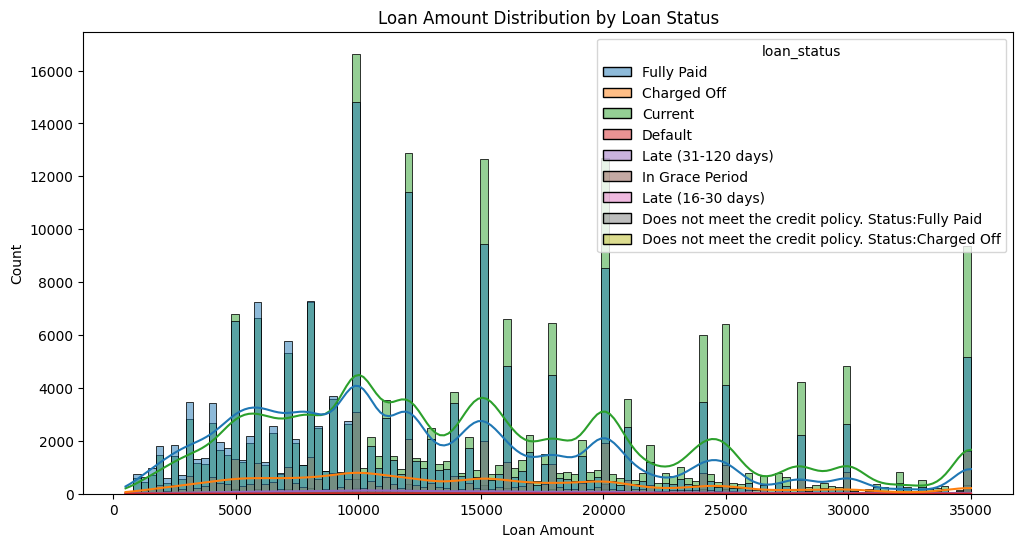

In [ ]:
# prompt: buat distribusi visualisasi loan amount by loan status

import matplotlib.pyplot as plt
import seaborn as sns # Added import for seaborn

plt.figure(figsize=(12, 6))
# Changed to using 'x' and 'hue' parameters correctly
sns.histplot(data=df, x='loan_amnt', hue='loan_status', kde=True)
plt.title('Loan Amount Distribution by Loan Status')
plt.xlabel('Loan Amount')
plt.ylabel('Count')
plt.show()


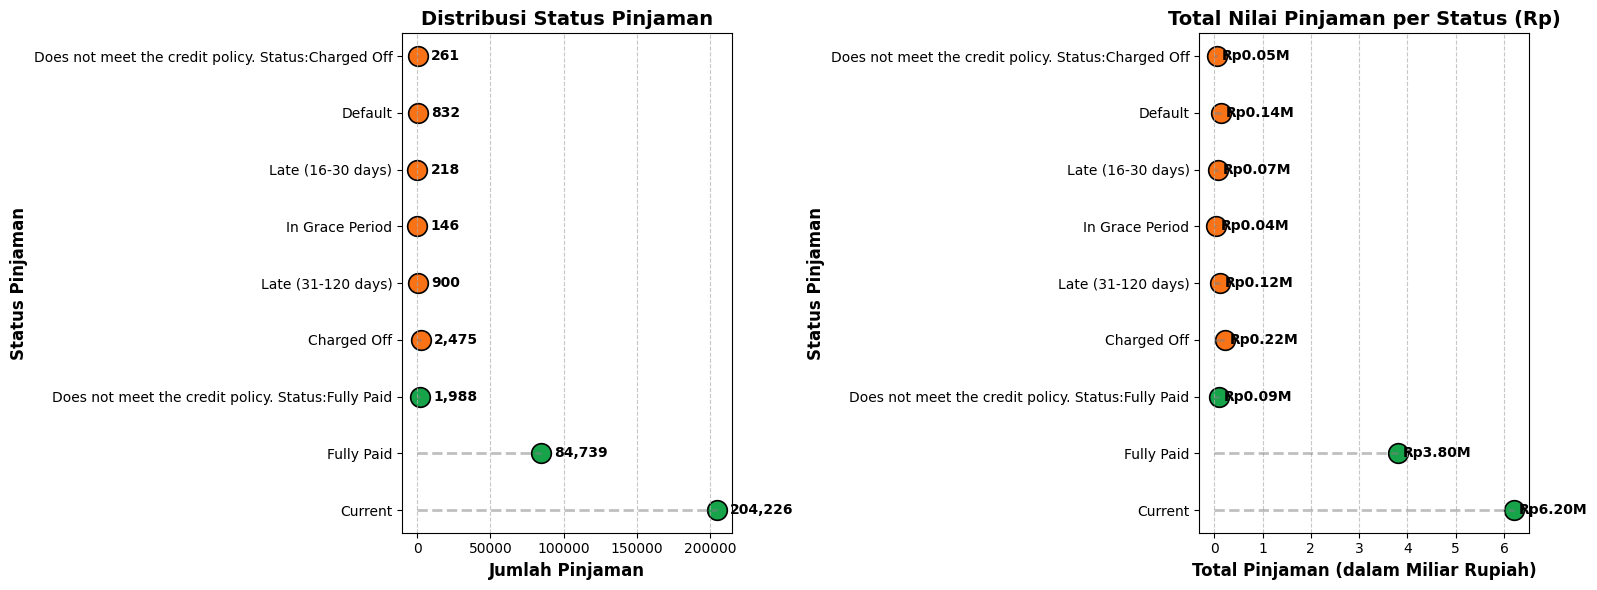

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Simulasi data (berdasarkan gambar dan kode sebelumnya)
loan_status = [
    'Current',
    'Fully Paid',
    'Does not meet the credit policy. Status:Fully Paid',
    'Charged Off',
    'Late (31-120 days)',
    'In Grace Period',
    'Late (16-30 days)',
    'Default',
    'Does not meet the credit policy. Status:Charged Off'
]
count = [204226, 84739, 1988, 2475, 900, 146, 218, 832, 261]
loan_amount = [6.2, 3.8, 0.09, 0.22, 0.12, 0.04, 0.07, 0.14, 0.05]  # Dalam miliar

# Warna kategori risiko
low_color = '#16A34A'  # hijau
high_color = '#F97316'  # oren

# Buat DataFrame
loan_status_counts = pd.DataFrame({
    'loan_status': loan_status,
    'count': count
})

sum_loan = pd.DataFrame({
    'loan_status': loan_status,
    'total_loan_amount': loan_amount
})

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Lollipop Chart 1
axes[0].hlines(y=loan_status_counts['loan_status'], xmin=0, xmax=loan_status_counts['count'],
               color='gray', alpha=0.5, linewidth=2, linestyle='dashed')
for i, row in loan_status_counts.iterrows():
    color = low_color if i < 3 else high_color
    axes[0].scatter(row['count'], row['loan_status'], s=200, color=color, edgecolors='black', linewidth=1.2)
    axes[0].text(row['count'] + 9000, row['loan_status'], f"{row['count']:,}", va='center', fontsize=10, fontweight='bold')

axes[0].set_title('Distribusi Status Pinjaman', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Jumlah Pinjaman', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Status Pinjaman', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# Lollipop Chart 2
axes[1].hlines(y=sum_loan['loan_status'], xmin=0, xmax=sum_loan['total_loan_amount'],
               color='gray', alpha=0.5, linewidth=2, linestyle='dashed')
for i, row in sum_loan.iterrows():
    color = low_color if i < 3 else high_color
    axes[1].scatter(row['total_loan_amount'], row['loan_status'], s=200, color=color, edgecolors='black', linewidth=1.2)
    axes[1].text(row['total_loan_amount'] + 0.1, row['loan_status'], f"Rp{row['total_loan_amount']:.2f}M",
                 va='center', fontsize=10, fontweight='bold')

axes[1].set_title('Total Nilai Pinjaman per Status (Rp)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Pinjaman (dalam Miliar Rupiah)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Status Pinjaman', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



**Insight**

1️⃣ Mayoritas pinjaman berstatus "Current" & "Fully Paid" = Indikator kondisi kredit yang masih sehat.

2️⃣ Jumlah pinjaman gagal bayar (Charged Off, Default, Late) masih signifikan = Risiko kredit yang perlu dimitigasi.

3️⃣ Total loan terbesar ada di kategori "Current" (3.40B) & "Fully Paid" (2.44B) = Sebagian besar dana masih berputar atau sudah dikembalikan.

4️⃣ Kategori "Late (31-120 days)" cukup besar (0.11B) = Jika tidak diintervensi, bisa berisiko masuk Charged Off/Default.

5️⃣ Perlu strategi pencegahan keterlambatan & peningkatan akurasi prediksi risiko kredit = Optimasi credit eligibility assessment

In [ ]:
# Define a function to map loan status to 'low-risk' or 'high-risk'
def map_loan_status(status):
    """
    Function to map loan status to 'high-risk' or 'low-risk'.
    Parameters:
    status (str): The loan status to be mapped.
    Returns:
    str: 'high-risk' if the status is in the list of default statuses, 'low-risk' otherwise.
    """
    default_statuses = [
        'Charged Off',
        'Late (31-120 days)',
        'Late (16-30 days)',
        'In Grace Period',
        'Default',
        'Does not meet the credit policy. Status:Charged Off'
    ]
    return 'high-risk' if status in default_statuses else 'low-risk'

# Apply the map_loan_status function
df['loan_status'] = df['loan_status'].apply(map_loan_status)


In [ ]:
# prompt: check nilai funded_amnt

print(df['funded_amnt'].describe())


count    466285.000000
mean      14291.801044
std        8274.371300
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       35000.000000
Name: funded_amnt, dtype: float64


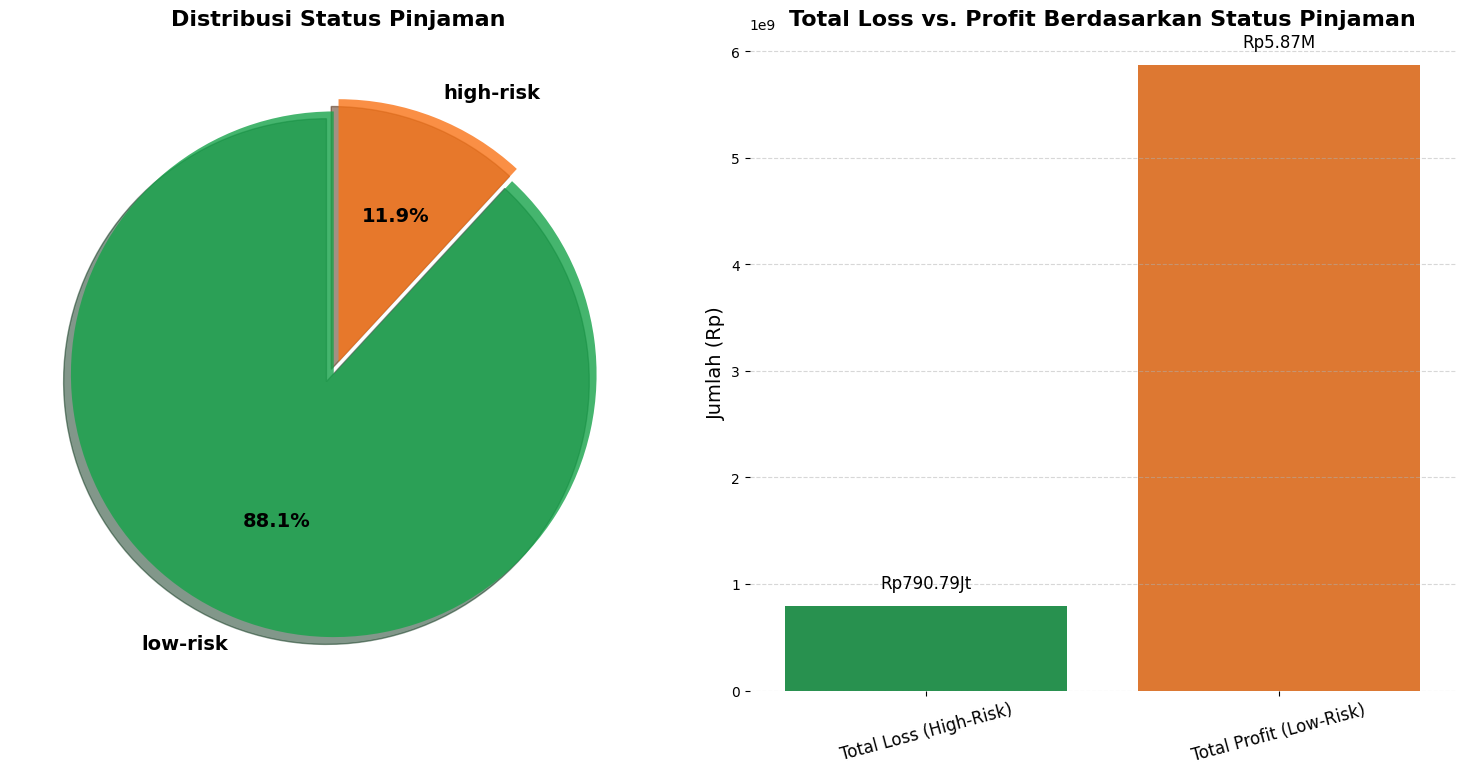

In [ ]:
# Set figure size
plt.figure(figsize=(15, 8))

# Warna untuk kategori risiko
colors = ['#16A34A', '#F97316']  # Hijau = Low-Risk, Oranye = High-Risk

### PIE CHART ###
plt.subplot(1, 2, 1)
loan_status_values = df['loan_status'].value_counts()
loan_status_labels = loan_status_values.index
explode = (0.05, 0)  # Eksplosi untuk High-Risk
plt.pie(
    loan_status_values, labels=loan_status_labels, autopct='%1.1f%%', startangle=90,
    colors=colors, explode=explode, textprops={'fontsize': 14, 'fontweight': 'bold'},
    shadow=True, wedgeprops={'alpha': 0.8}
)
plt.title('Distribusi Status Pinjaman', fontsize=16, fontweight='bold')

# Hitung total loss dan profit dalam Rupiah
avg_loans = df['funded_amnt'].mean()
total_high_risk = df.loan_status.value_counts()[1]
total_low_risk = df.loan_status.value_counts()[0]
total_loss = avg_loans * total_high_risk
total_profit = avg_loans * total_low_risk

# Fungsi format angka ke Rupiah dengan satuan
def format_amount_rupiah(value):
    if value >= 1_000_000_000:
        return f"Rp{value / 1_000_000_000:.2f}M"  # Miliar
    elif value >= 1_000_000:
        return f"Rp{value / 1_000_000:.2f}Jt"  # Juta
    else:
        return f"Rp{value:,.0f}"

# DataFrame untuk bar chart
target_viz = pd.DataFrame({
    'Metrics': ['Total Loss (High-Risk)', 'Total Profit (Low-Risk)'],
    'Amount': [total_loss, total_profit]
})

### BAR CHART ###
plt.subplot(1, 2, 2)
ax = sns.barplot(x='Metrics', y='Amount', data=target_viz, palette=colors)

# Tampilkan angka di atas batang
for p in ax.patches:
    ax.annotate(format_amount_rupiah(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.title('Total Loss vs. Profit Berdasarkan Status Pinjaman', fontsize=16, fontweight='bold')
plt.ylabel('Jumlah (Rp)', fontsize=14)
plt.xlabel('')
plt.xticks(rotation=15, fontsize=12)
sns.despine(left=True, bottom=True)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [ ]:
# prompt: check loan_status unik

df['loan_status'].unique()


array(['low-risk', 'high-risk'], dtype=object)

In [ ]:
df.loan_status.value_counts()

,count
loan_status,
low-risk,410953
high-risk,55332


Data menunjukkan adanya ketimpangan dalam distribusi status pinjaman. Setelah dikategorikan menjadi Low-Risk (Pinjaman Baik) dan High-Risk (Pinjaman Buruk), terlihat bahwa 88,1% dari total pinjaman termasuk kategori Low-Risk, sedangkan 11,9% merupakan High-Risk.

Dari sisi keuangan, total pembayaran pinjaman yang berhasil diterima dari Low-Risk mencapai 5,87 miliar dolar, sementara kerugian akibat pinjaman High-Risk mencapai 790,79 juta dolar. Meskipun jumlah pinjaman Low-Risk jauh lebih besar, angka kerugian dari High-Risk tetap signifikan dan perlu mendapat perhatian serius.

🚨 Tantangan Utama: Kehilangan hampir 790,79 juta dolar akibat gagal bayar merupakan risiko besar yang dapat berdampak pada stabilitas keuangan dalam jangka panjang. Jika tidak dikelola dengan baik, angka ini dapat terus meningkat, menggerus profitabilitas bisnis secara keseluruhan.

### Function for Visualization

#### Function to create lineplot

In [ ]:
def create_lineplot(x, y, data, hue=None, target_colors=None, bbox_to_anchor=None):
    """
    Creates a line plot for the given data.

    Parameters:
    x (str): The name of the column in 'data' to be used for the x-axis.
    y (str): The name of the column in 'data' to be used for the y-axis.
    data (DataFrame): The data to plot.
    hue (str, optional): The name of the column in 'data' to be used for color encoding. If None, no hue encoding is applied.
    target_colors (list, optional): A list of colors to use for the different levels of the 'hue' variable. If None, the default colors are used.
    bbox_to_anchor (tuple, optional): The anchor point for the legend. If None, the legend is placed in the upper right corner.

    Returns:
    None
    """
    # Define linewidth and marker here
    linewidth = 2.5  # Example value, you can adjust it
    marker = 'o'     # Example value, you can use other markers like 's', '^', etc.

    # Create line plot
    ax = sns.lineplot(
        x=x, y=y, data=data,
        palette=target_colors, hue=hue,
        errorbar=None, linewidth=linewidth, marker=marker, markersize=7, alpha=0.85
    )

    # Set the title and labels
    plt.title(f'{hue.replace("_", " ").title()} {y.replace("_", " ").title()} by {x.replace("_", " ").title()}', fontsize=18, fontweight='bold', y=1.09)
    plt.xlabel(f'{x}', fontsize=12.5, labelpad=10, loc='right')
    plt.ylabel(f'{y.replace("_", " ").title()}', fontsize=12.5)

    # Add a legend
    plt.legend(title=hue.replace("_", " ").title(), loc='upper right', bbox_to_anchor=bbox_to_anchor)

    # Add grid for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove the top and right spines from plot
    sns.despine()

#### Function to plot stacked bar chart

In [ ]:
def create_stacked_barchart(data, value_col, status_col, order=None, target_colors=None, bbox_to_anchor=None):
    """
    Creates a stacked bar chart showing the proportion of good and bad loans for each category in a specified column.

    Parameters:
    - data (DataFrame): The data to plot.
    - value_col (str): Column name for the x-axis categories.
    - status_col (str): Column name for loan status.
    - order (list, optional): Custom order for x-axis categories.
    - target_colors (list, optional): Colors for 'Low-Risk' and 'High-Risk' bars.
    - bbox_to_anchor (tuple, optional): Legend position.

    Returns:
    None
    """
  # Hitung distribusi status pinjaman dalam setiap kategori (normalisasi ke persen)
    lstatus_props = data.groupby(value_col)[status_col].value_counts(normalize=True).unstack().fillna(0) * 100

    # Reorder kategori jika diberikan
    # Check if 'order' is not empty instead of just 'if order:'
    if order is not None and len(order) > 0:
        lstatus_props = lstatus_props.reindex(order)

    # Buat stacked bar chart
    ax = lstatus_props.plot(kind='bar', stacked=True, color=target_colors, figsize=(8, 6))


    # Tambahkan persentase di dalam setiap bar
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()

        if height > 0:  # Hanya tampilkan kalau ada nilai
            text_color = 'white' if p.get_facecolor()[:3] == (0.976, 0.451, 0.086) else 'black'  # Warna teks dinamis
            ax.annotate(f'{height:.1f}%',
                        (x + width / 2, y + height / 2),
                        ha='center', va='center', fontsize=10, fontweight='bold', color=text_color)

    # Set label dan title
    plt.xlabel(value_col.replace('_', ' ').title(), fontsize=14, fontweight='bold')
    plt.ylabel('Percentage of Loans (%)', fontsize=12, fontweight='bold')
    plt.title(f'High-Risk Loan Rate by {value_col.replace("_", " ").title()}', fontsize=14, fontweight='bold', y=1.05)

    # Styling sumbu
    plt.xticks(rotation=25)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Tambahkan legend
    plt.legend(title='Loan Status', loc='upper right', bbox_to_anchor=bbox_to_anchor, fontsize=10)


#### Function to create countplot and barplot

In [ ]:
def create_countplot(x, data, hue=None, order=None, palette=None):
    """
    Function to create a count plot using seaborn.

    Parameters:
    x (str): The name of the column to be plotted on the x-axis.
    y (str): The name of the column to be plotted on the y-axis.
    data (DataFrame): The DataFrame containing the data to be plotted.
    hue (str): The variable in data to map plot aspects to different colors.
    order (list): The order to plot the categorical levels in.
    palette (str or dict): Method for choosing the colors to use when mapping the hue semantic.

    Returns:
    None
    """
    # Create a count plot with the specified parameters
    sns.countplot(x=x, data=data, hue=hue, order=order, palette=palette)

    # Remove the top and right spines from plot
    sns.despine()

    # Set the title of the plot
    plt.title(f'Client Distribution by {x.replace("_", " ").title()}', fontsize=18, fontweight='bold', y=1.09)

    # Set the label of the x-axis
    plt.xlabel(f'{x.replace("_", " ").title()}', fontsize=12.5, loc='right')

    # Set the label of the y-axis
    plt.ylabel('Client', fontsize=12.5)


def create_barplot(x, y, data, hue=None, order=None, palette=None):
    """
    Function to create a bar plot using seaborn.

    Parameters:
    x (str): The name of the column to be plotted on the x-axis.
    y (str): The name of the column to be plotted on the y-axis.
    data (DataFrame): The DataFrame containing the data to be plotted.
    order (list): The order to plot the categorical levels in.
    palette (str or dict): Method for choosing the colors to use when mapping the hue semantic.

    Returns:
    None
    """
    # Create a bar plot with the specified parameters
    sns.barplot(x=x, y=y, data=data, hue=hue, order=order, palette=palette)

    # Remove the top and right spines from plot
    sns.despine()

    # Set the title of the plot
    plt.title(f'{y.replace("_", " ").title()} by {x.replace("_", " ").title()}', fontsize=18, fontweight='bold', y=1.09)

    # Set the label of the x-axis
    plt.xlabel(f'{x.replace("_", " ").title()}', fontsize=12.5, loc='right')

    # Set the label of the y-axis
    plt.ylabel(f'{y.replace("_", " ").title()}', fontsize=12.5)

### Distribution of Loan Amount Based on Risk

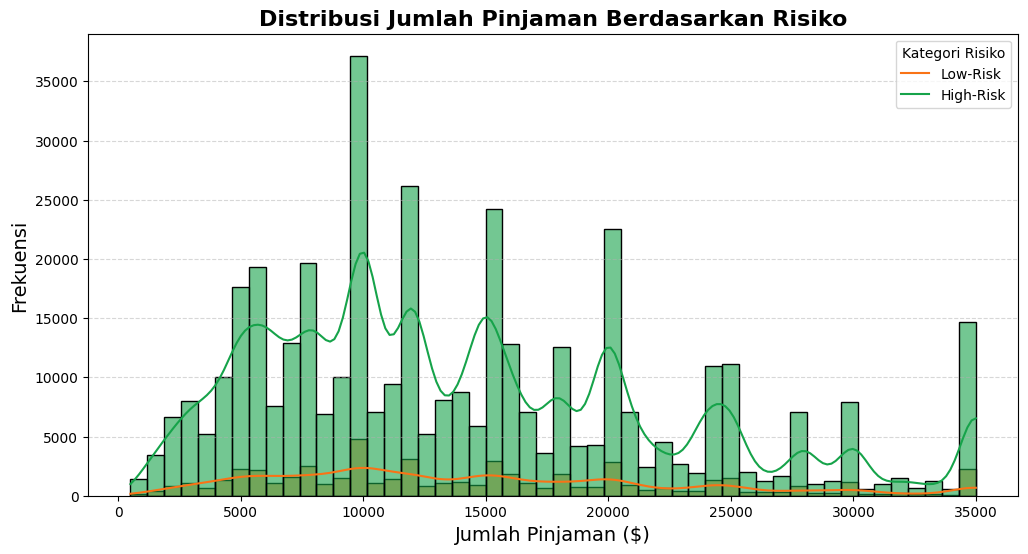

In [ ]:
# Set figure size
plt.figure(figsize=(12, 6))

# Histogram dengan KDE Plot untuk melihat distribusi jumlah pinjaman
sns.histplot(df, x='funded_amnt', hue='loan_status', kde=True, bins=50, palette=['#16A34A', '#F97316'], alpha=0.6)

# Styling plot
plt.title('Distribusi Jumlah Pinjaman Berdasarkan Risiko', fontsize=16, fontweight='bold')
plt.xlabel('Jumlah Pinjaman ($)', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.legend(title='Kategori Risiko', labels=['Low-Risk', 'High-Risk'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Menampilkan plot
plt.show()


### **Loan status by Year Analysis**

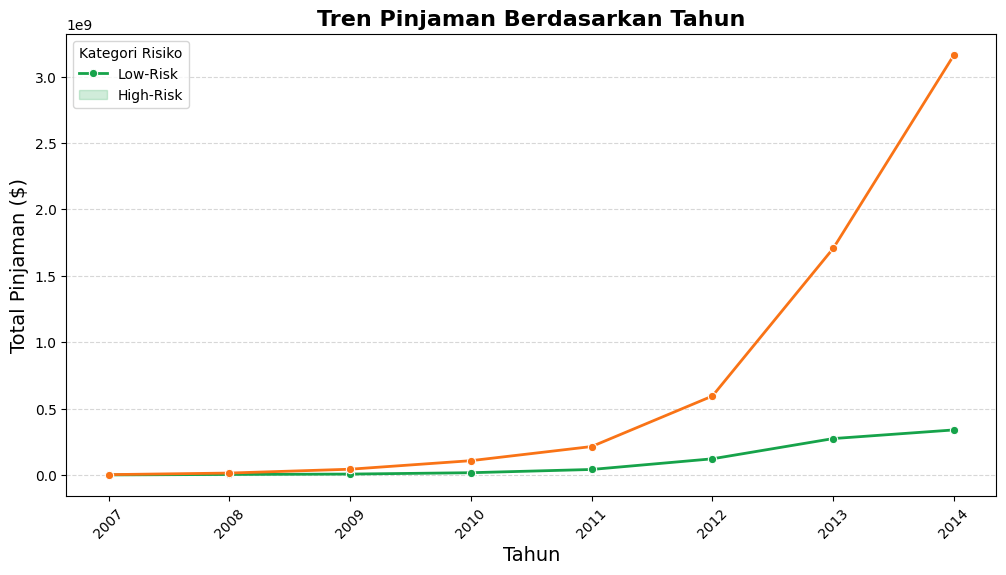

In [ ]:
# Kelompokkan jumlah pinjaman berdasarkan tahun dan kategori risiko
df['year'] = df['issue_d'].dt.year
yearly_funded = df.groupby(['year', 'loan_status'])['funded_amnt'].sum().reset_index()

# Set figure size
plt.figure(figsize=(12, 6))

# Plot garis tren untuk Low-Risk dan High-Risk
sns.lineplot(data=yearly_funded, x='year', y='funded_amnt', hue='loan_status',
             palette=['#16A34A', '#F97316'], marker='o', linewidth=2)

# Styling
plt.title('Tren Pinjaman Berdasarkan Tahun', fontsize=16, fontweight='bold')
plt.xlabel('Tahun', fontsize=14)
plt.ylabel('Total Pinjaman ($)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Kategori Risiko', labels=['Low-Risk', 'High-Risk'])

# Menampilkan plot
plt.show()


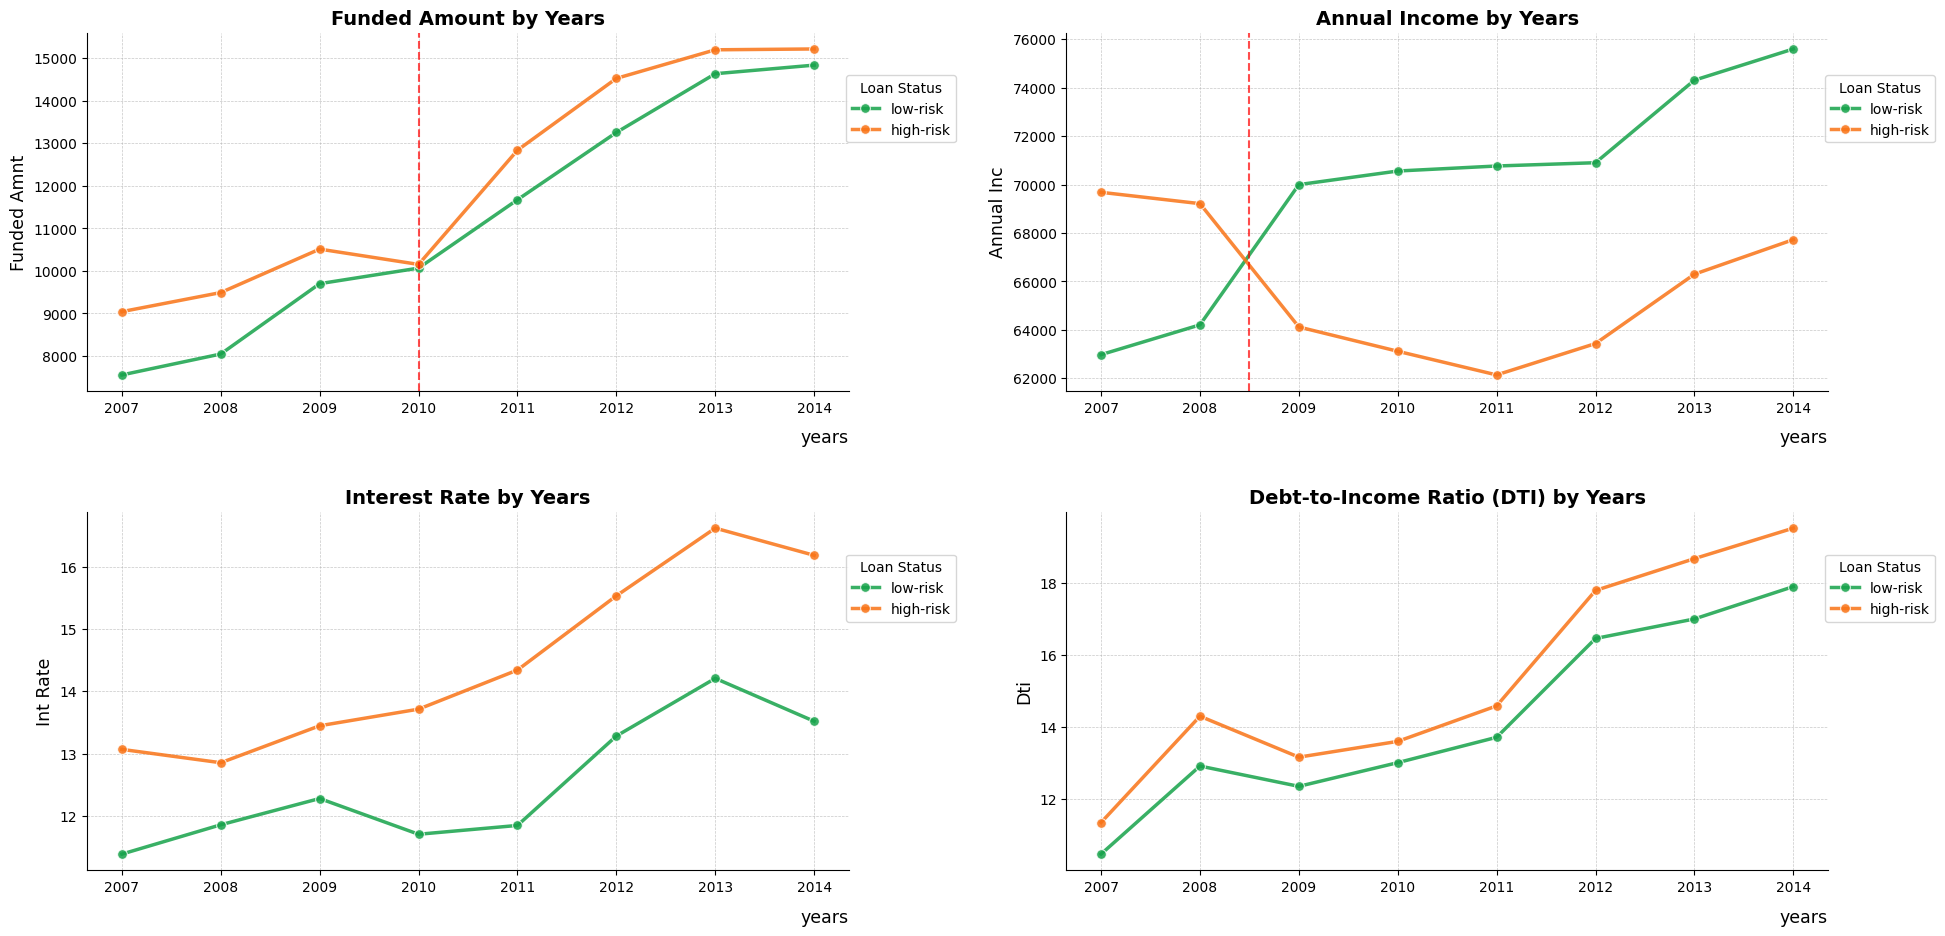

In [ ]:
import matplotlib.pyplot as plt

# Tema warna baru (Hijau untuk Low-Risk, Oranye untuk High-Risk)
colors = ['#16A34A', '#F97316']

plt.figure(figsize=(20, 10))  # Ukuran plot lebih proporsional

# Subplot 1: Funded Amount
plt.subplot(2, 2, 1)
create_lineplot('years', 'funded_amnt', df, hue='loan_status', target_colors=colors, bbox_to_anchor=(1.15, 0.9))
plt.axvline(x=2010, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
plt.title("Funded Amount by Years", fontsize=14, fontweight='bold')

# Subplot 2: Annual Income
plt.subplot(2, 2, 2)
create_lineplot('years', 'annual_inc', df, hue='loan_status', target_colors=colors, bbox_to_anchor=(1.15, 0.9))
plt.axvline(x=2008.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
plt.title("Annual Income by Years", fontsize=14, fontweight='bold')

# Subplot 3: Interest Rate
plt.subplot(2, 2, 3)
create_lineplot('years', 'int_rate', df, hue='loan_status', target_colors=colors, bbox_to_anchor=(1.15, 0.9))
plt.title("Interest Rate by Years", fontsize=14, fontweight='bold')

# Subplot 4: Debt-to-Income Ratio (DTI)
plt.subplot(2, 2, 4)
create_lineplot('years', 'dti', df, hue='loan_status', target_colors=colors, bbox_to_anchor=(1.15, 0.9))
plt.title("Debt-to-Income Ratio (DTI) by Years", fontsize=14, fontweight='bold')

# Mengatur tata letak agar lebih rapi
plt.tight_layout(pad=3)
plt.show()


**Insight**

1️⃣ Funded Amount by Years:

Tren: Terdapat peningkatan signifikan dalam jumlah dana yang disetujui dari tahun 2007 hingga 2014, dengan penurunan tajam pada tahun 2009. Pada tahun 2013 dan seterusnya, jumlah pinjaman risiko rendah dan tinggi semakin mendekati dan stagnasi pada level yang sama.

Actionable Insight: Pemberi pinjaman harus memanfaatkan tren ini untuk memperluas penawaran produk pinjaman, tetapi juga harus mempertimbangkan strategi mitigasi risiko untuk tahun-tahun di mana penurunan terjadi.

2️⃣ Annual Income by Years:

Tren: Pendapatan tahunan menunjukkan fluktuasi, dengan penurunan yang jelas pada tahun 2009, diikuti oleh pemulihan bertahap.

Actionable Insight: Pemberi pinjaman dapat menggunakan data pendapatan untuk menyesuaikan kriteria kelayakan pinjaman, memastikan bahwa peminjam memiliki kapasitas untuk membayar kembali pinjaman, terutama di tahun-tahun dengan pendapatan rendah.


3️⃣ Interest Rate by Years:

Tren: Tingkat suku bunga menunjukkan peningkatan yang stabil dari tahun 2007 hingga 2014, dengan sedikit penurunan pada tahun 2010.

Actionable Insight: Pemberi pinjaman harus mempertimbangkan untuk menyesuaikan suku bunga berdasarkan kondisi pasar dan risiko yang teridentifikasi, serta menawarkan produk pinjaman dengan suku bunga kompetitif untuk menarik peminjam.

4️⃣ Debt-to-Income Ratio (DTI) by Years:

Tren: Rasio DTI menunjukkan peningkatan yang konsisten, terutama setelah tahun 2009.

Actionable Insight: Pemberi pinjaman perlu menetapkan batasan DTI yang lebih ketat untuk mengurangi risiko default, serta memberikan edukasi kepada peminjam tentang manajemen utang yang sehat.

1️⃣ Tren Pinjaman Berdasarkan Risiko:

Tren: Terdapat kenaikan signifikan dalam total pinjaman berisiko tinggi (high-risk) dari tahun 2007 hingga 2014, dengan pertumbuhan yang sangat pesat mulai tahun 2012. Sementara itu, pinjaman berisiko rendah (low-risk) tetap stagnan dan menunjukkan pertumbuhan yang jauh lebih lambat.

Actionable Insight: Pemberi pinjaman harus mempertimbangkan untuk menyesuaikan strategi penilaian risiko dan pengelolaan portofolio, mengingat pertumbuhan pesat pinjaman berisiko tinggi. Ini juga dapat mencakup pengembangan produk pinjaman yang lebih sesuai untuk peminjam berisiko tinggi.

### **Client Distribution & High Risk Loan Rate by State**

In [ ]:
# Data region sesuai kota
West = ['CA', 'NV', 'UT', 'CO', 'WY', 'MT', 'ID', 'OR', 'WA', 'AK', 'HI']
Southwest = ['AZ', 'NM', 'TX', 'OK']
Midwest = ['ND', 'MN', 'SD', 'NE', 'KS', 'MO', 'IA', 'WI', 'IL', 'IN', 'OH', 'MI']
Southeast = ['AR', 'LA', 'MS', 'AL', 'GA', 'TN', 'KY', 'NC', 'SC', 'WV', 'DC', 'VA', 'DE', 'FL']
Northeast = ['PA', 'MD', 'NJ', 'NY', 'CT', 'RI', 'MA', 'NH', 'VT', 'ME']

def us_region(state):
    """
    Function to map US state to its corresponding region.

    Parameters:
    state (str): The US state abbreviation.

    Returns:
    str: The region where the state is located.
    """
    # Check if the state is in the West region
    if state in West:
        return 'West'
    # Check if the state is in the Southwest region
    elif state in Southwest:
        return 'Southwest'
    # Check if the state is in the Midwest region
    elif state in Midwest:
        return 'Midwest'
    # Check if the state is in the Southeast region
    elif state in Southeast:
        return 'Southeast'
    # Check if the state is in the Northeast region
    elif state in Northeast:
        return 'Northeast'
    # If the state is not in any of the defined regions, return 'Other'
    else:
        return 'Other'

# Apply the function us_region to 'addr_state' column
# This will create a new column 'region' in the dataframe df
df['region'] = df['addr_state'].apply(us_region)

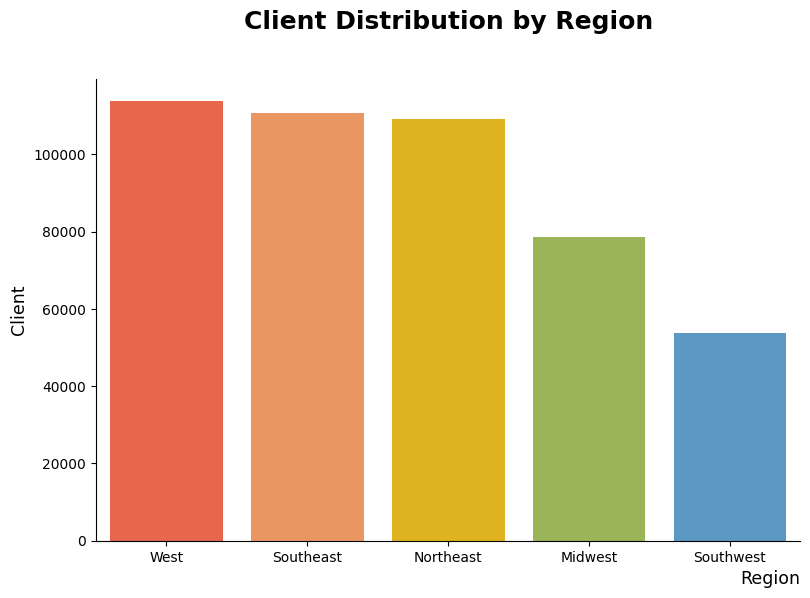

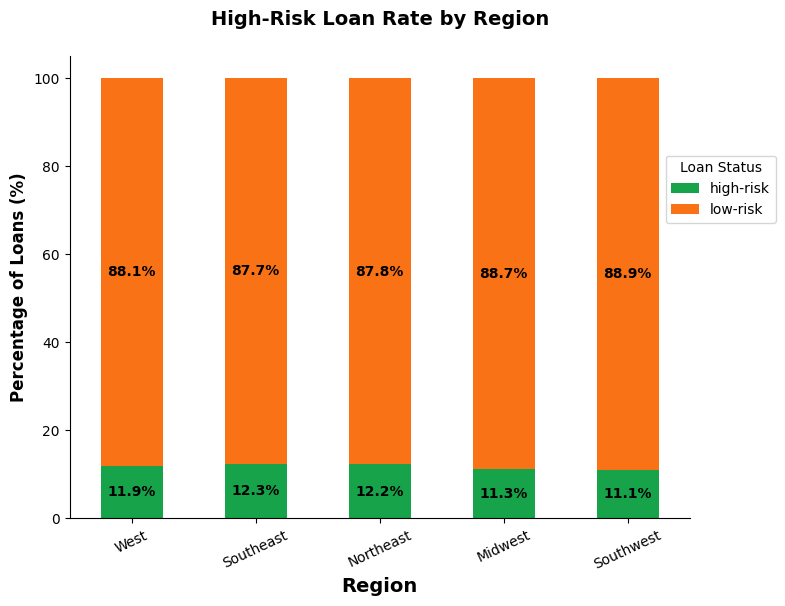

In [ ]:
region_order = df.region.value_counts().index
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
region_colors = ['#FF5733', '#FF914D', '#FFC300', '#A1C349', '#4B9CD3']
create_countplot('region', df, order=region_order, palette=region_colors) # Changed 'pregion' to 'region_colors'

create_stacked_barchart(df, 'region', 'loan_status', order=region_order, target_colors=['#16A34A', '#F97316'], bbox_to_anchor=(1.15, 0.8))

Insight dari Distribusi Klien Berdasarkan Wilayah

1️⃣ Distribusi Klien Berdasarkan Wilayah:

Tren: Wilayah West mendominasi jumlah klien, diikuti oleh Southeast dan Northeast. Sementara itu, Midwest dan Southwest tertinggal jauh, dengan Southwest sebagai yang terendah.

Actionable Insight: Perluas jangkauan di Midwest dan Southwest! Tingkatkan strategi pemasaran dan penawaran produk untuk memperluas pangsa pasar dan menarik lebih banyak klien.

2️⃣ Tingkat Pinjaman Berisiko Tinggi Berdasarkan Wilayah:

 Tren: Mayoritas pinjaman di semua wilayah tergolong aman! Wilayah West paling stabil dengan hanya 11.9% pinjaman berisiko tinggi, sementara Southeast (12.3%) dan Northeast (12.2%) sedikit lebih tinggi. Midwest dan Southwest bahkan lebih rendah, masing-masing 11.3% dan 11.1%.

Actionable Insight: Perkuat ekspansi di wilayah dengan risiko rendah untuk pertumbuhan yang stabil. Sementara itu, dorong edukasi finansial di wilayah dengan risiko lebih tinggi untuk membantu peminjam mengelola utang dengan lebih baik.

### **Client Distribution & High Risk Loan Rate by Top 5 State Analysis**

In [ ]:
df.addr_state.value_counts().head(10)

,count
addr_state,
CA,71450
NY,40242
TX,36439
FL,31637
IL,18612
NJ,18061
PA,16424
OH,15237
GA,14975


In [ ]:
pip install geopandas matplotlib pandas

In [ ]:
print(df.loan_status.unique())

['low-risk' 'high-risk']


In [ ]:
!pip install us

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import us
from geopy.geocoders import Nominatim
import time

# Data asli dari addr_state
df_state_counts = pd.DataFrame({
    'state': ['CA', 'NY', 'TX', 'FL', 'IL', 'NJ', 'PA', 'OH', 'GA', 'VA'],
    'count': [71450, 40242, 36439, 31637, 18612, 18061, 16424, 15237, 14975, 14222]
})

# Ambil nama lengkap state
df_state_counts['name'] = df_state_counts['state'].apply(lambda x: us.states.lookup(x).name)

# Inisialisasi geolocator
geolocator = Nominatim(user_agent="state_locator")

# Fungsi untuk ambil lat/lon
def get_lat_lon(state_name):
    try:
        location = geolocator.geocode(state_name + ", USA")
        time.sleep(1)  # Untuk menghindari limit API
        return pd.Series([location.latitude, location.longitude])
    except:
        return pd.Series([None, None])

# Ambil koordinat untuk masing-masing nama state
df_state_counts[['lat', 'lon']] = df_state_counts['name'].apply(get_lat_lon)

# Plot peta
fig = go.Figure()

# Choropleth
fig.add_trace(go.Choropleth(
    locations=df_state_counts['state'],
    z=df_state_counts['count'],
    locationmode='USA-states',
    colorscale='Blues',
    colorbar_title="Clients Count"
))

# Tambahkan label nama state
fig.add_trace(go.Scattergeo(
    lon=df_state_counts['lon'],
    lat=df_state_counts['lat'],
    text=df_state_counts['name'],
    mode='text',
    textfont=dict(size=10, color="black"),
    showlegend=False
))

# Layout
fig.update_layout(
    title_text='Client Distribution by State (Auto Label from addr_state)',
    geo=dict(scope='usa', showland=True, landcolor='rgb(240,240,240)'),
    width=1112,
    height=600
)

fig.show()



In [ ]:
import plotly.graph_objects as go

# Count the number of clients in each state
state_counts = df['addr_state'].value_counts()

# Create a data frame with state abbreviations and counts
df_state_counts = pd.DataFrame({'state': state_counts.index, 'count': state_counts.values})

# Create a choropleth map using plotly
fig = go.Figure(data=go.Choropleth(
    locations=df_state_counts['state'],  # State abbreviations
    z=df_state_counts['count'].astype(float),  # Number of clients in each state
    locationmode='USA-states',  # Set of locations match entries in `locations`
    colorscale='Blues',  # Adjusted colorscale
    colorbar_title="Clients Count",  # Title for the color bar
))

# Update the layout of the figure
fig.update_layout(
    title={
        'text': "Client Distribustion by State",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            size=20,
            color="black"
        )
    },
    geo_scope='usa',  # Limit map scope to USA
    width=1112,  # Width of the figure
    height=600  # Height of the figure
)

# Display the figure
fig.show()


# Calculate the number of defaults for each state
defaults = df[df['loan_status'] == 'high-risk']['addr_state'].value_counts()

# Calculate the default rate for each state
default_rate = (defaults / state_counts).fillna(0)

# Create a data frame with state abbreviations and default rates
df_state_default_rate = pd.DataFrame({'state': default_rate.index, 'default_rate': default_rate.values})

# Create a choropleth map using plotly
fig = go.Figure(data=go.Choropleth(
    locations=df_state_default_rate['state'],  # State abbreviations
    z=df_state_default_rate['default_rate'].astype(float),  # Default rate in each state
    locationmode='USA-states',
    colorscale='Reds', # Adjusted colorscale for default rate
    colorbar_title="Default Rate",  # Title for the color bar
    zmin=0, # Set minimum value for default rate to 0
    zmax=default_rate.max() # Set maximum value to the highest default rate

))


# Update the layout of the figure
fig.update_layout(
    title={
        'text': "Default Rate by State",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            size=20,
            color="black"
        )
    },
    geo_scope='usa',  # Limit map scope to USA
    width=1112,  # Width of the figure
    height=600  # Height of the figure
)
fig.show()


1️⃣ Distribusi Klien Berdasarkan Negara Bagian:

Tren: California mendominasi dengan 71,450 klien, diikuti oleh New York (40,422) dan Texas (36,639). Florida (36,137) dan Illinois (18,612) juga mencatat jumlah klien yang signifikan, sementara Virginia (14,222) lebih rendah.

Actionable Insight: Maksimalkan potensi pasar di wilayah dengan basis klien besar! Perkuat strategi pemasaran dan perluas penawaran produk di California dan New York untuk meningkatkan pertumbuhan.

<Figure size 1200x600 with 0 Axes>

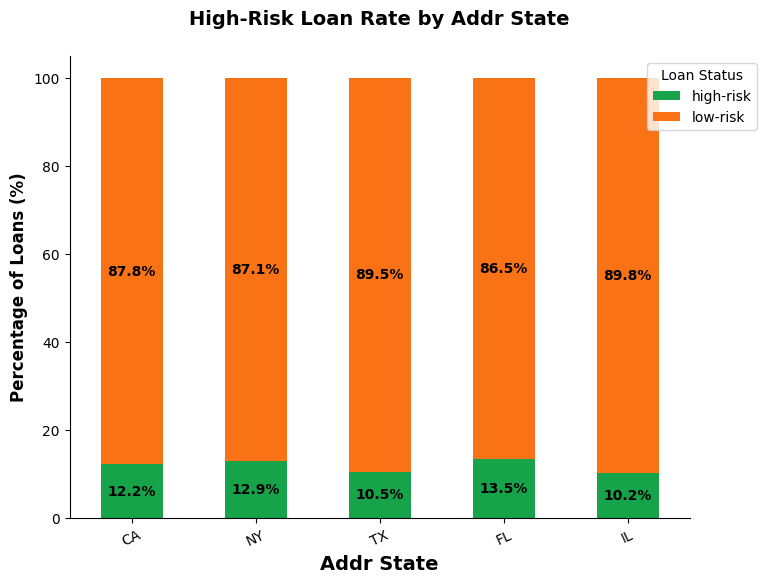

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import plotly.graph_objects as go

# Palet warna yang disesuaikan
colors = ['#16A34A', '#F97316']  # Contoh: Biru untuk Low-Risk, Merah untuk High-Risk

# Create a stacked barchart of loan statuses for the top 5 states to see the default rate
# Get the top 5 states by loan count
top_states = df.addr_state.value_counts().head(5).index
# Filter the dataframe to only include the top 5 states
df_top_states = df[df.addr_state.isin(top_states)]

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a stacked bar plot using the function `create_stacked_barchart`
create_stacked_barchart(df_top_states, 'addr_state', 'loan_status', top_states, colors, (1.12, 1))


Insight dari Tingkat Pinjaman Berisiko Tinggi Berdasarkan Negara Bagian

1️⃣ Tingkat Pinjaman Berisiko Tinggi:

Tren: Beberapa negara bagian mencatat proporsi pinjaman berisiko tinggi yang cukup signifikan. California (12.2%) dan New York (12.9%) menunjukkan angka yang mirip, sementara Texas (10.5%) lebih rendah. Florida menjadi perhatian dengan 13.5%, tertinggi di antara lima negara bagian utama.

Actionable Insight: Fokus mitigasi risiko di wilayah dengan tingkat pinjaman tinggi! Optimalkan penilaian kredit dan strategi suku bunga untuk menekan gagal bayar.

### **Client Distribution & High Risk Loan Rate by Grade Analysis**

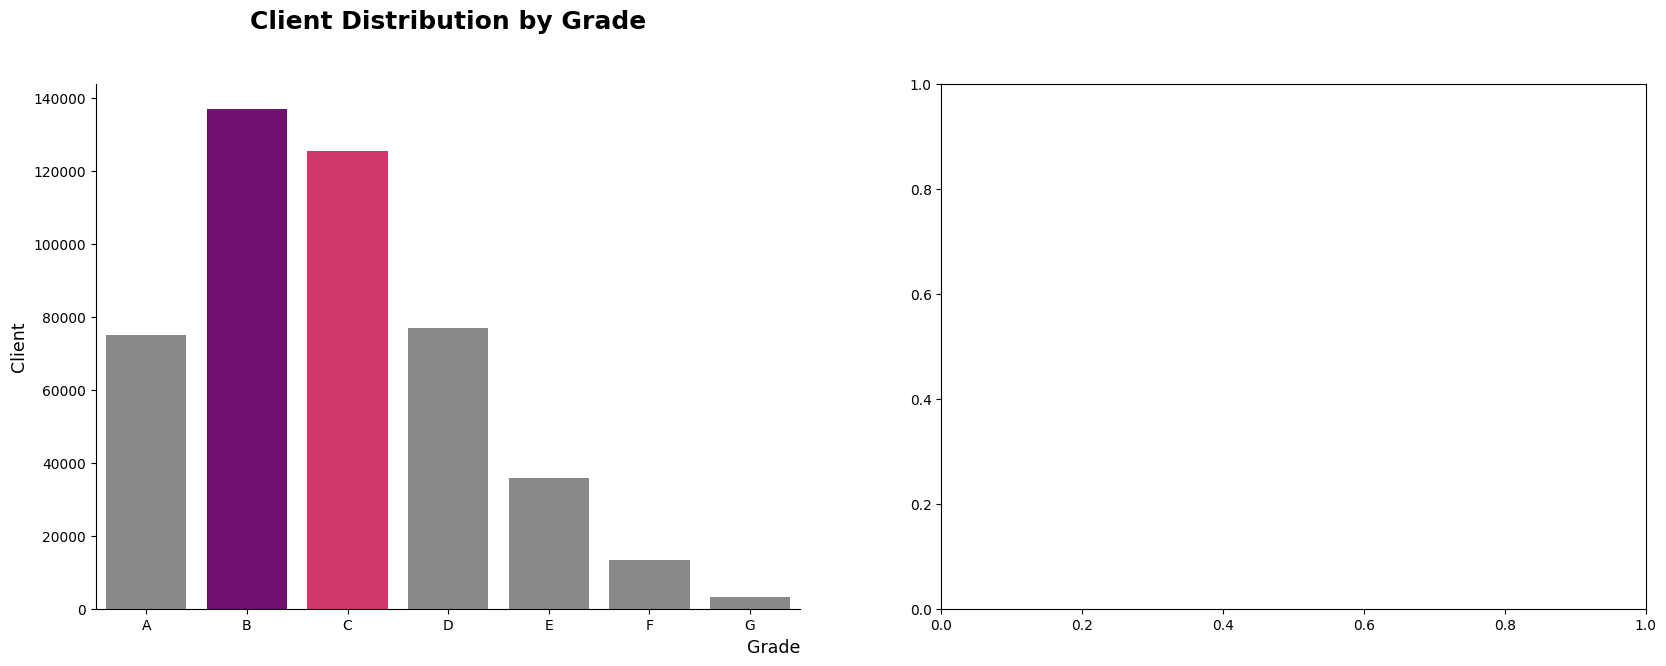

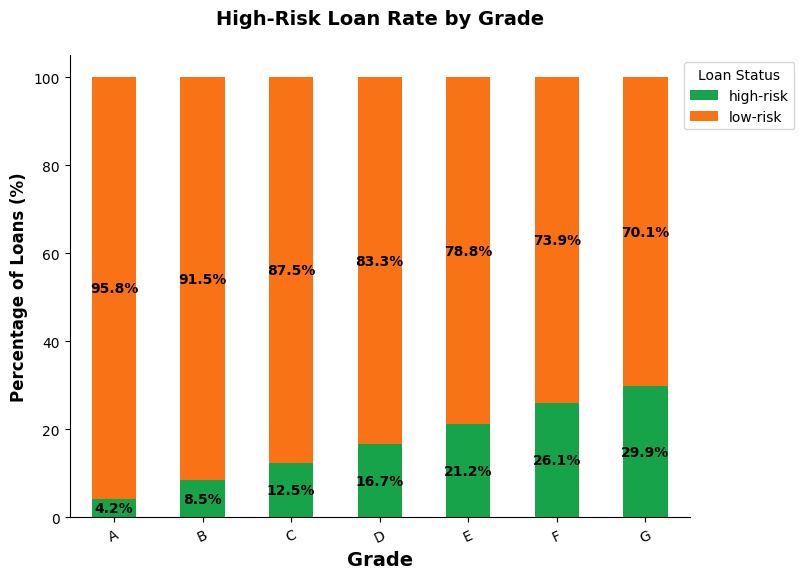

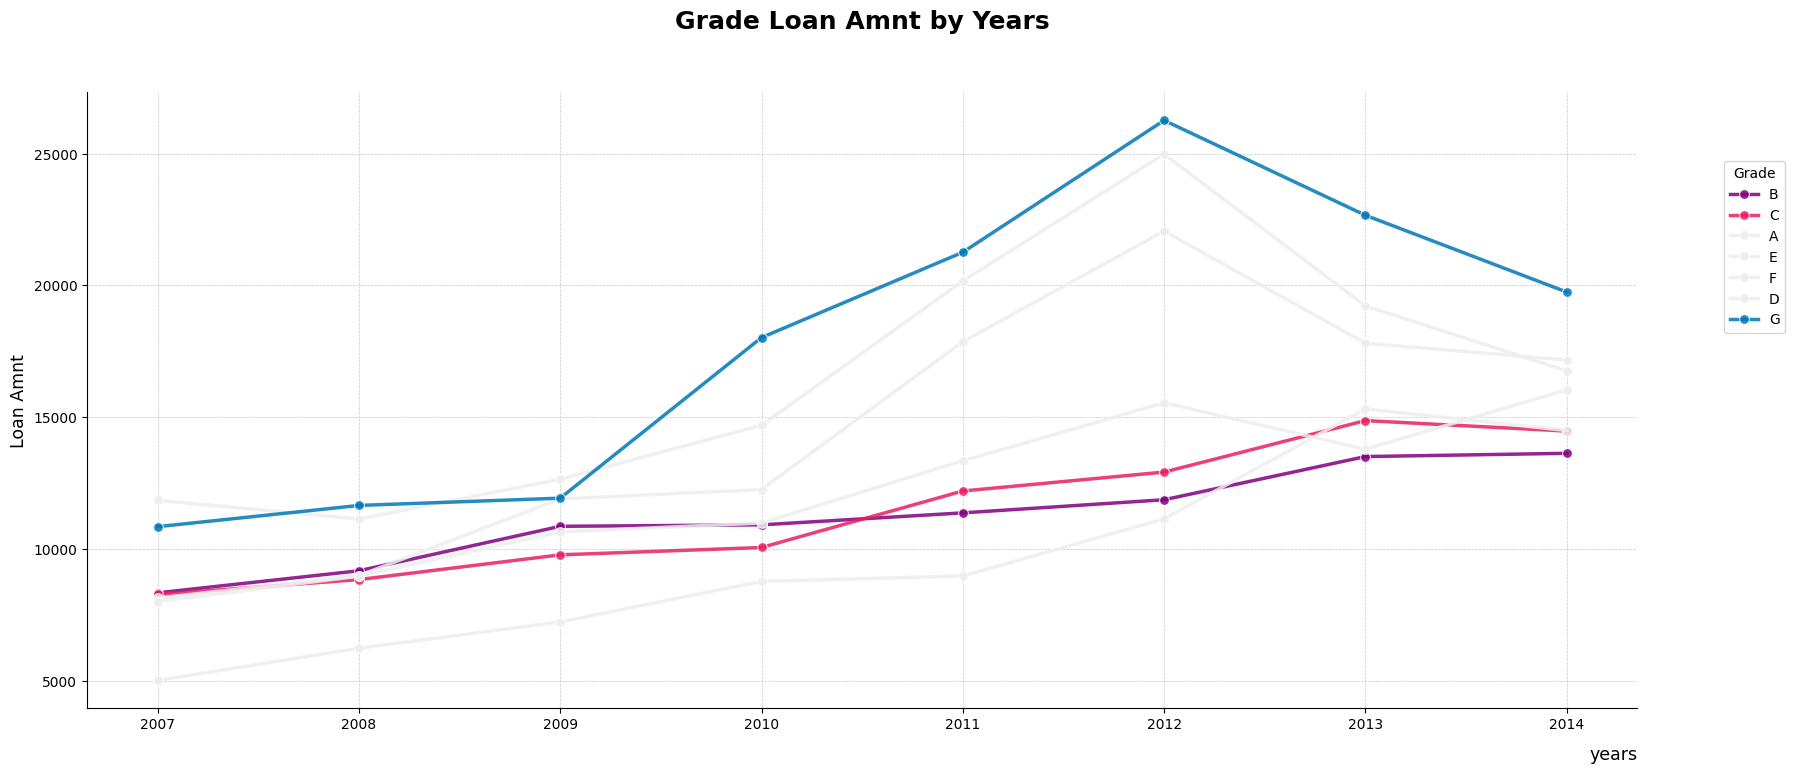

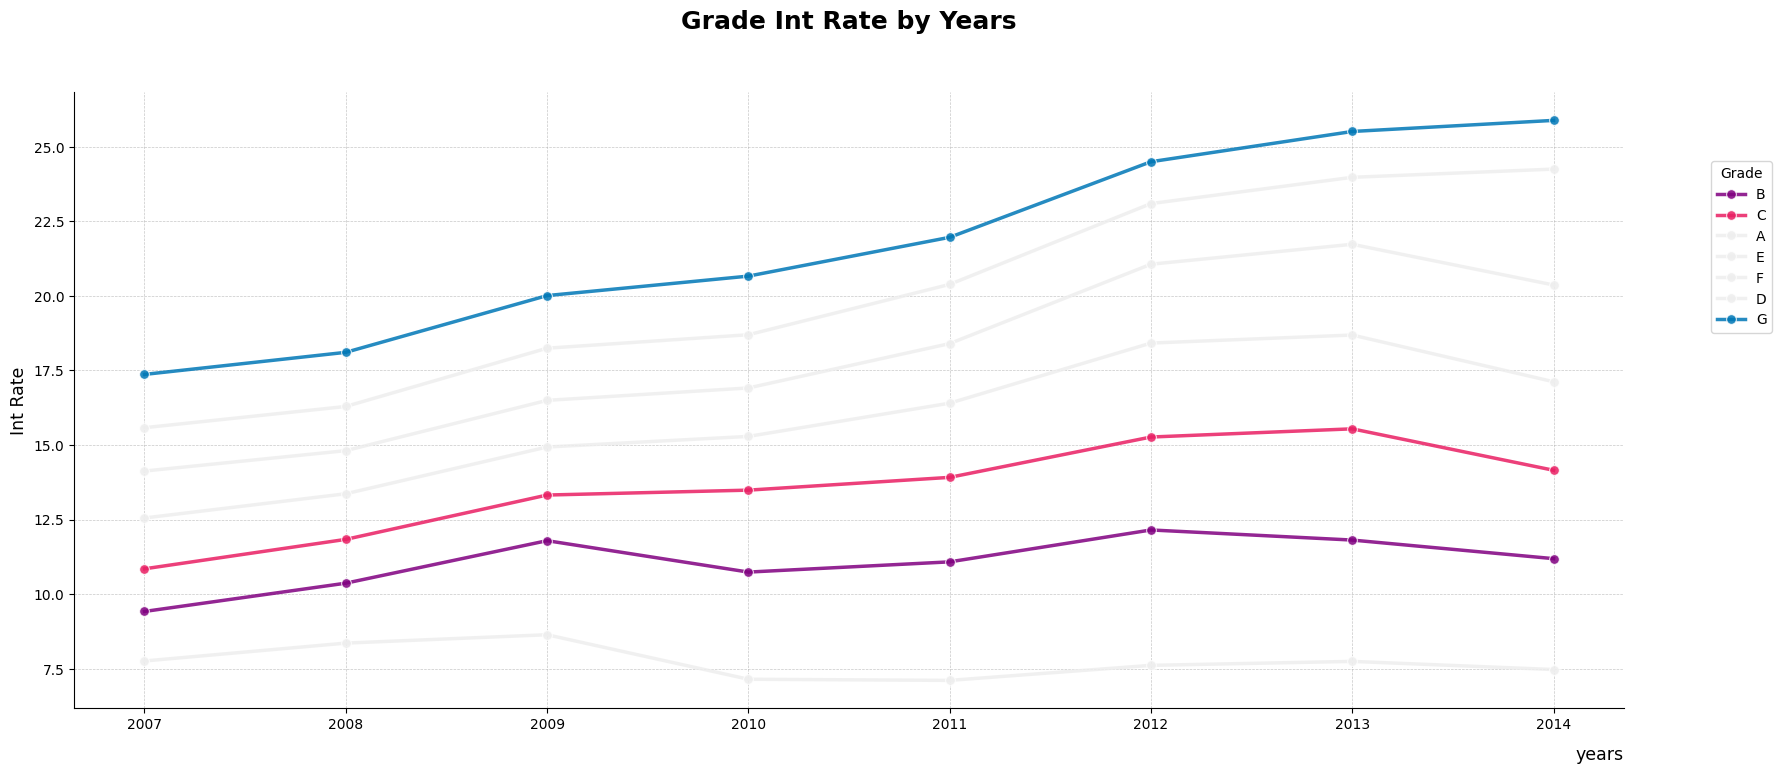

In [ ]:
# Set the figure size
plt.figure(figsize=(20, 15))  # Further increased figure height for better spacing

# Define color mappings
order_grade = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
grade_colors = ['#898989'] + ['#800080', '#E91E63'] + ['#898989'] * 5
target_colors = ['#16A34A', '#F97316']
grade_color = {
    'A': '#EEEEEE', 'B': '#800080', 'C': '#E91E63',
    'D': '#EEEEEE', 'E': '#EEEEEE', 'F': '#EEEEEE', 'G': '#0077B6'
}

# Create the first subplot (Countplot for Grade)
plt.subplot(2, 2, 1)
create_countplot('grade', df, order=order_grade, palette=grade_colors)

# Create the second subplot (Stacked Bar Chart for Loan Status by Grade)
plt.subplot(2, 2, 2)
create_stacked_barchart(df, 'grade', 'loan_status', order_grade, target_colors, bbox_to_anchor=(1.18, 1))

# Create the third subplot (Lineplot for Loan Amount over Years by Grade) - Enlarged
plt.figure(figsize=(20, 8))  # Further increased figure size for better clarity
create_lineplot('years', 'loan_amnt', df, 'grade', target_colors=grade_color, bbox_to_anchor=(1.1, 0.9))

# Create the fourth subplot (Lineplot for Interest Rate over Years by Grade) - Enlarged
plt.figure(figsize=(20, 8))  # Separate figure with increased size
create_lineplot('years', 'int_rate', df, 'grade', target_colors=grade_color, bbox_to_anchor=(1.1, 0.9))

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.26)
plt.show()

2️⃣ Loan Trends & Interest Rates (2007-2014)

Tren : Seiring waktu, Grade G menarik banyak pendanaan, tetapi tingginya suku bunga membuatnya berisiko. Grade B & C tumbuh stabil, sementara Grade A tetap paling aman dengan pendanaan dan risiko terendah. Grade D-F terus meningkat, namun dengan risiko yang perlu dikendalikan.

Actionable insight : Prioritaskan A, B, C untuk pertumbuhan stabil, Pantau D-F sebelum risikonya membesar. Hati-hati dengan G – butuh strategi lebih ketat!

### **Client Distribution & High Risk Loan Rate by Purpose Analysis**

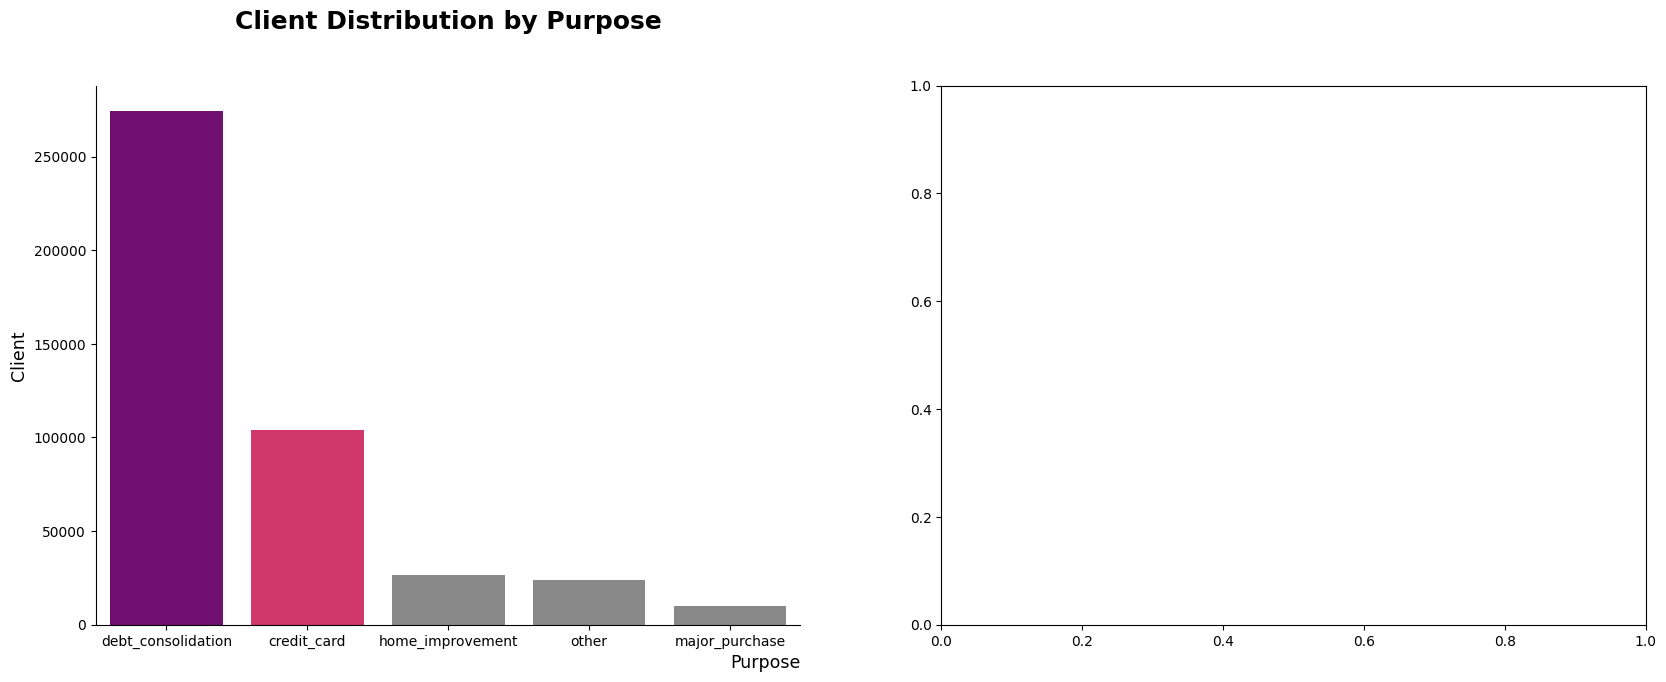

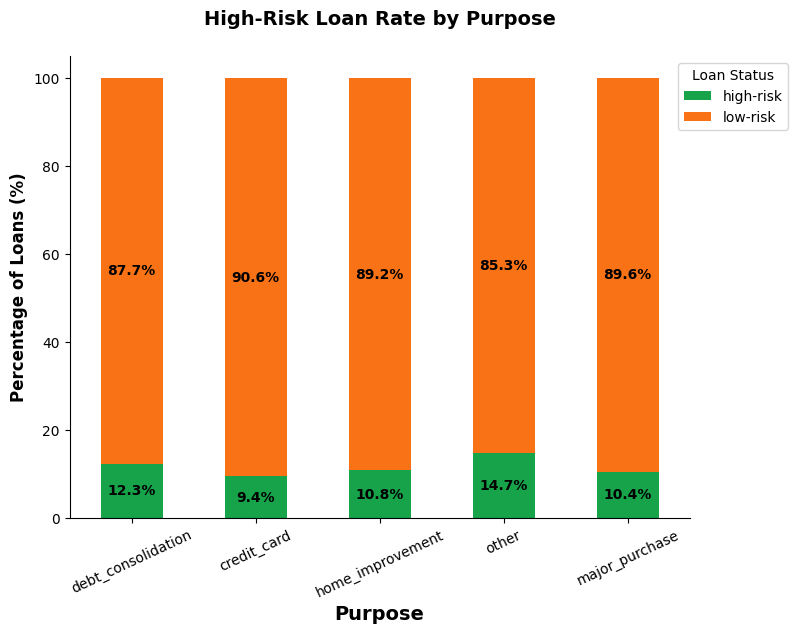

In [ ]:
# Definisikan warna untuk top 2 purpose dan sisanya
top_2_colors = ['#800080', '#E91E63']
other_color = '#898989'

# Get the top 5 purposes from the dataframe
top_purposes = df['purpose'].value_counts().head(5).index.tolist()

# Buat daftar warna berdasarkan urutan top_purposes
purpose_colors = [top_2_colors[i] if i < 2 else other_color for i in range(len(top_purposes))]

# Set figure size yang lebih proporsional
plt.figure(figsize=(20, 7))

# Buat subplot pertama (Countplot Purpose)
plt.subplot(1, 2, 1)
create_countplot('purpose', df, order=top_purposes, palette=purpose_colors)

# Buat subplot kedua (Stacked Bar Chart Loan Status by Purpose)
plt.subplot(1, 2, 2)
create_stacked_barchart(df, 'purpose', 'loan_status', top_purposes, target_colors, bbox_to_anchor=(1.17, 1))

# Sesuaikan jarak antar subplot
plt.subplots_adjust(wspace=0.3)
plt.show()



**Loan Purpose & Risk Analysis by Purpose**

Tren :
Debt consolidation & credit card mendominasi, mencerminkan tingginya kebutuhan pengelolaan utang, Sebagian besar pinjaman memiliki risiko rendah (>85%), serta kategori other dan best_consolidation menunjukkan tingkat risiko lebih tinggi.

Actionable Insight:

Fokus pada konsolidasi utang & kartu kredit, perketat analisis risiko untuk home improvement & other

### **Client Distribution & High Risk Loan Rate by Purpose Analysis**

NameError: name 'target_colors' is not defined

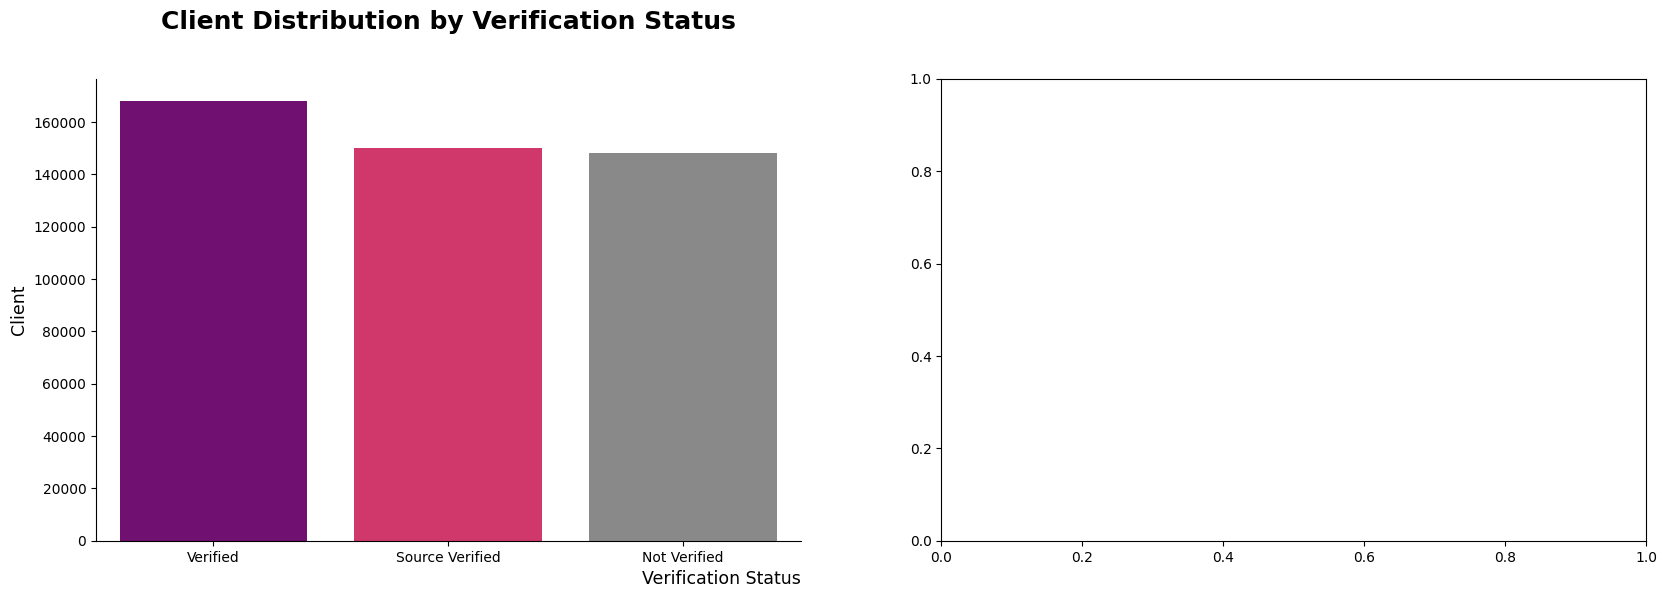

In [ ]:
verification_order = df.verification_status.value_counts().index
plt.figure(figsize=(20, 6))
set_color = ['#800080', '#E91E63'] + ['#898989'] * 4
plt.subplot(1, 2, 1)
create_countplot('verification_status', df, order=verification_order, palette=set_color)

plt.subplot(1, 2, 2)
create_stacked_barchart(df, 'verification_status', 'loan_status', df.verification_status.value_counts().index, target_colors, bbox_to_anchor=(1.16, 1))

sns.despine()
plt.tight_layout()
plt.show()

1️⃣ Verification Status & Loan Risk

Tren:
Mayoritas peminjam memiliki status verifikasi, tetapi semakin rendah tingkat verifikasi, semakin tinggi risiko gagal bayar.

Actionable Insight:
Fokus pada peminjam terverifikasi untuk mengurangi risiko, perketat aturan bagi yang tidak terverifikasi!

### **Correlation Multivariate Analysis**

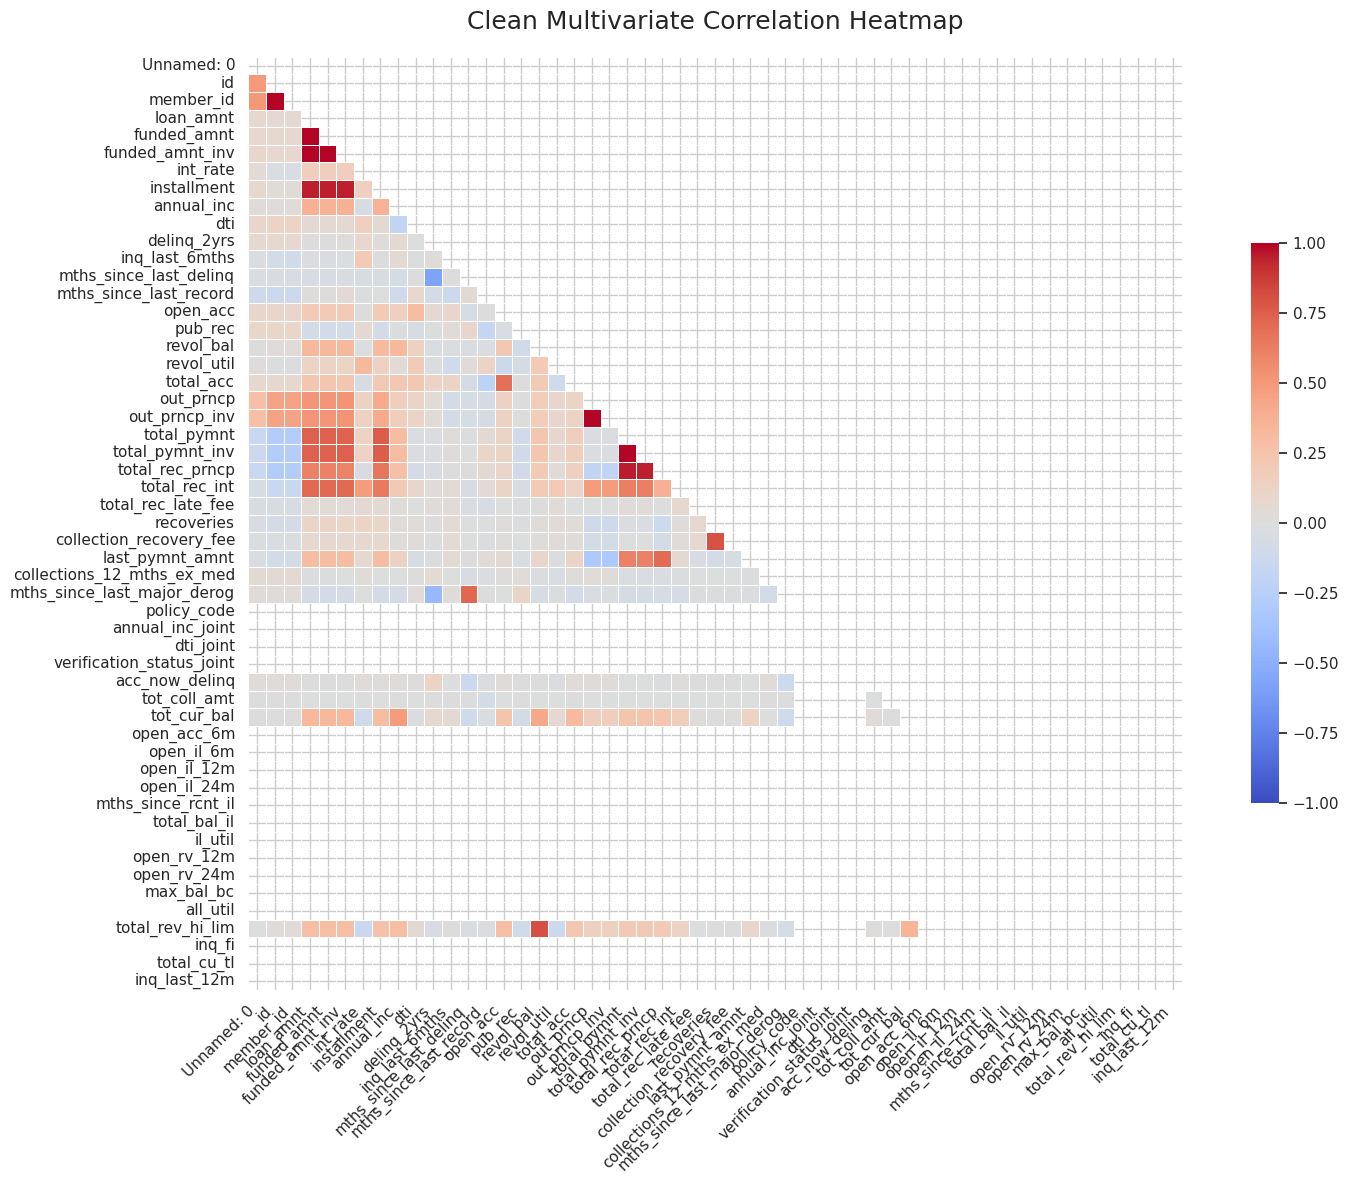

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Ambil hanya kolom numerik dari df
df_num = df.select_dtypes(include='number')

# 2. Hitung korelasi
df_cor = df_num.corr()

# 3. Mask segitiga atas untuk clarity
mask = np.triu(np.ones_like(df_cor, dtype=bool))

# 4. Visualisasi heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(df_cor,
            mask=mask,
            cmap="coolwarm",
            vmin=-1, vmax=1,
            annot=False,  # Ganti True kalau mau angka korelasi ditampilkan
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .6})

plt.title("Clean Multivariate Correlation Heatmap", fontsize=18, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


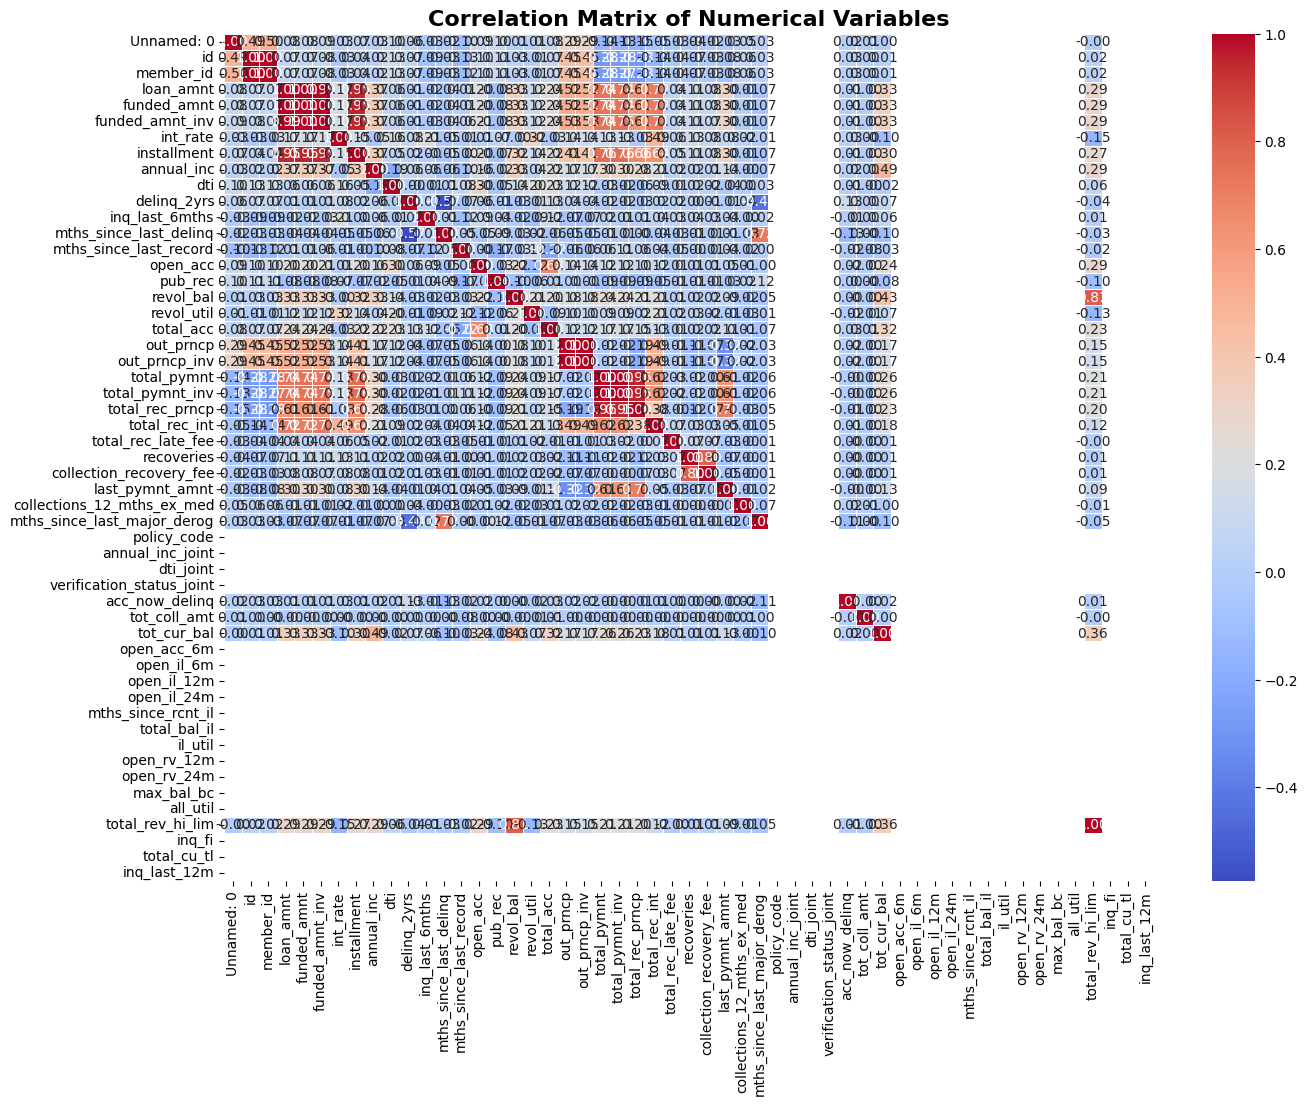

In [ ]:
# Ambil kolom numerik dari X_filtered
numeric_cols = df_cor.select_dtypes(include=['number'])

# Hitung korelasi
num_corr = numeric_cols.corr()

# Plot heatmap korelasi
plt.figure(figsize=(15, 11))
sns.heatmap(num_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables', fontsize=16, fontweight='bold')
plt.show()